# TODO

- change arm_df name to all_years_armd_df or all_years_im_df
- perhaps ImpactTrajectory or ImpactMetrics instead of RiskMertics
- Update the calc_measure_cash_flows_df

# CB Refactoring

In [1]:
import numpy as np

from climada.util.api_client import Client
from climada.entity import ImpactFunc

from climada.entity import LitPop

import copy
client = Client()


## Parameters

In [2]:
# Parameters
ctr_str = 'DEU'

# Years to be considered
years = [2000, 2020, 2050]

# Step 1. Create the snapshot collection 
- Exposure, Hazard sets, Impact Functions

### Exposure

In [3]:
exp_hist = LitPop().from_countries(countries=ctr_str, reference_year=years[0])

# Assign random Group_id of 3 possible to the gdf
reg_id_arr = np.random.randint(0, 3, exp_hist.gdf.shape[0])
exp_hist.gdf['region_id'] = reg_id_arr

# Present
exp_pres = LitPop().from_countries(countries=ctr_str, reference_year=years[1])
# Assign the region_ids
exp_pres.gdf['region_id'] = reg_id_arr

# Future
exp_fut =copy.deepcopy(exp_pres)
# Exponential growth
exp_growth_rate = 0.01
exp_fut.gdf.value = exp_fut.gdf.value * (1 + exp_growth_rate)**(years[2] - years[1])
# Assign the region_ids
exp_fut.gdf['region_id'] = reg_id_arr

2024-07-01 16:06:12,804 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: DEU (276)...

2024-07-01 16:06:12,830 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-07-01 16:06:12,843 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-07-01 16:06:12,855 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-07-01 16:06:12,865 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-07-01 16:06:12,878 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-07-01 16:06:12,890 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-07-01 16:06:12,901 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-07-01 16:06:12,912 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-07-01 16:06:12,922 - climada.entity.exposures.litpop.gpw_population - 

## Hazard sets

In [4]:
haz_fl_1980 = client.get_hazard(
    hazard_type='river_flood',
    properties={
        'climate_scenario' : 'historical',
        'year_range': '1980_2000',
        'country_iso3alpha': 'DEU'
    })

haz_fl_2010 = client.get_hazard(
    hazard_type='river_flood',
    properties={
        'climate_scenario' : 'rcp85',
        'year_range': '2010_2030',
        'country_iso3alpha': 'DEU'
    })

haz_fl_2030 = client.get_hazard(
    hazard_type='river_flood',
    properties={
        'climate_scenario' : 'rcp85',
        'year_range': '2030_2050',
        'country_iso3alpha': 'DEU'
    })

2024-07-01 16:06:24,425 - climada.hazard.io - INFO - Reading /Users/vwattin/climada/data/hazard/river_flood/river_flood_150arcsec_hist_DEU_1980_2000/v2/river_flood_150arcsec_hist_DEU_1980_2000.hdf5
2024-07-01 16:06:29,757 - climada.hazard.io - INFO - Reading /Users/vwattin/climada/data/hazard/river_flood/river_flood_150arcsec_rcp85_DEU_2010_2030/v3/river_flood_150arcsec_rcp85_DEU_2010_2030.hdf5
2024-07-01 16:06:35,284 - climada.hazard.io - INFO - Reading /Users/vwattin/climada/data/hazard/river_flood/river_flood_150arcsec_rcp85_DEU_2030_2050/v3/river_flood_150arcsec_rcp85_DEU_2030_2050.hdf5


### Impact Functions

array([<Axes: title={'center': 'RF 1: Flood Africa JRC Residential noPAA'}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
       <Axes: title={'center': 'RF 2: Flood Asia JRC Residential noPAA'}, xlabel='Intensity (m)', ylabel='Impact (%)'>],
      dtype=object)

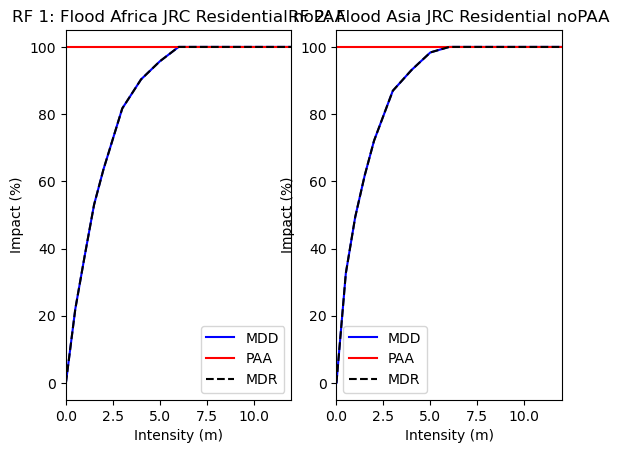

In [5]:
from climada_petals.entity.impact_funcs.river_flood import ImpfRiverFlood, flood_imp_func_set
from climada.entity import ImpactFunc, ImpactFuncSet

impf_set_flood = flood_imp_func_set()

impf_1 = impf_set_flood.get_func(fun_id=1, haz_type='RF')
impf_2 = impf_set_flood.get_func(fun_id=2, haz_type='RF')
impfset = ImpactFuncSet([impf_1, impf_2])


impfset.plot()

### Assign Impact Functions ID

In [6]:
def assign_impfid(exp_hist, exp_pres, exp_fut, case='single'):
    if case=='single':
        exp_hist.gdf['impf_RF'] = 1
        exp_pres.gdf['impf_RF'] = 1
        exp_fut.gdf['impf_RF'] = 1
    if case=='multiple_spatial':
        exp_hist.gdf.loc[:len(exp_hist.gdf/2),'impf_RF'] = 1
        exp_pres.gdf[:len(exp_pres.gdf/2),'impf_RF'] = 1
        exp_fut.gdf[:len(exp_fut.gdf/2),'impf_RF'] = 1
        exp_hist.gdf.loc[len(exp_hist.gdf/2):,'impf_RF'] = 2
        exp_pres.gdf[len(exp_pres.gdf/2):,'impf_RF'] = 2
        exp_fut.gdf[len(exp_fut.gdf/2):,'impf_RF'] = 2
    if case=='multiple_temp':
        exp_hist.gdf['impf_RF'] = 2
        exp_pres.gdf['impf_RF'] = 1
        exp_fut.gdf['impf_RF'] = 1
    if case == 'multiple':
        exp_hist.gdf.loc[:len(exp_hist.gdf/2),'impf_RF'] = 1
        exp_pres.gdf[:len(exp_hist.gdf/2),'impf_RF'] = 2
        exp_fut.gdf[:len(exp_hist.gdf/2),'impf_RF'] = 1
        exp_hist.gdf.loc[len(exp_hist.gdf/2):,'impf_RF'] = 2
        exp_pres.gdf[len(exp_hist.gdf/2):,'impf_RF'] = 1
        exp_fut.gdf[len(exp_hist.gdf/2):,'impf_RF'] = 2

### Create the Snapshot Collection

In [7]:
from climada.engine.impact_trajectories import Snapshot, SnapshotsCollection, CalcImpactsSnapshots

assign_impfid(exp_hist, exp_pres, exp_fut, case='single')
assign_impfid(exp_hist, exp_pres, exp_fut, case='multiple_temp')

hazard_list = [haz_fl_1980, haz_fl_2010, haz_fl_2030]
exposure_list = [exp_hist, exp_pres, exp_fut]
snapshot_years = years

snapshots = SnapshotsCollection.from_lists( hazard_list, exposure_list, impfset, snapshot_years)

# Create an arr
snap_years_range = np.array(range(snapshots.snapshots_years[0], snapshots.snapshots_years[-1]+1))


### Define the measures

In [8]:
# Define the measure
from climada.entity.measures.base import Measure, helper_hazard, helper_impfset, helper_exposure
from climada.entity.measures import MeasureSet

# Add to measure set list
meas_list = []

# Measure
haz_func = helper_hazard(0.8, 0)
exp_func = helper_exposure(reassign_impf_id=1, haz_type='RF')
impfset_func = helper_impfset(haz_type='RF')
# CostIncome attributes
cost_inc_attr_dict = {'mkt_price_year': 2000, 'init_cost': -10_000_000, 'annual_cost': -500_000, 'annual_income': 30_000, 'cost_growth_rate': 0.02, 'income_growth_rate': 0.07}

meas1 = Measure(
    name='Hazard_Int_Red_08', start_year=2000, end_year=2050,
    exposures_change=exp_func, impfset_change=impfset_func, hazard_change=haz_func, haz_type = 'RF', 
    **cost_inc_attr_dict
    )
meas_list.append(meas1)

# Measure
haz_func = helper_hazard(0.6, 0)
exp_func = helper_exposure(reassign_impf_id=1, haz_type='RF')
impfset_func = helper_impfset(haz_type='RF', impf_mdd_modifier={2: (0.6, 0)})
# CostIncome attributes
cost_inc_attr_dict = {'mkt_price_year': 2000, 'init_cost': -10_200_000, 'annual_cost': -600_000, 'annual_income': 35_000, 'cost_growth_rate': 0.02, 'income_growth_rate': 0.07}

meas2 = Measure(
    name='Hazard_Int_Red_07', start_year=2015, end_year=2035,
    exposures_change=exp_func, impfset_change=impfset_func, hazard_change=haz_func, haz_type = 'RF',
    **cost_inc_attr_dict
    )
meas_list.append(meas2)

# Measure
haz_func = helper_hazard(0.5, 0)
exp_func = helper_exposure(reassign_impf_id=1, haz_type='RF')
impfset_func = helper_impfset(haz_type='RF', impf_mdd_modifier={2: (0.6, 0)})
# CostIncome attributes
cost_inc_attr_dict = {'mkt_price_year': 2000, 'init_cost': -10_500_000, 'annual_cost': -100_000, 'annual_income': 40_000, 'cost_growth_rate': 0.02, 'income_growth_rate': 0.07}
meas3 = Measure(
    name='Hazard_Int_Red_06', start_year=2030, end_year=2040,
    exposures_change=exp_func, impfset_change=impfset_func, hazard_change=haz_func, haz_type = 'RF',
    **cost_inc_attr_dict
    )
meas_list.append(meas3)


# Create the measure set
measure_set = MeasureSet(meas_list)


## Get the necessary combos to consider overlapping time frames

### Create a combo set 

In [32]:
import pandas as pd

def get_meas_times_df(measure_set, incl_combo=False):
    """
    Get a DataFrame with the start and end years of the measures in a MeasureSet

    Parameters
    ----------
    MeasureSet : MeasureSet
        The measure set

    Returns
    -------
    pd.DataFrame
        DataFrame with the start and end years of the measures
    """

    cols = ['measure', 'start_year', 'end_year']
    meas_times_df = pd.DataFrame(columns=cols)

    # Populate the df
    for _,meas in measure_set.measures().items():

        # Skip combo measures if not included
        if not incl_combo and meas.combo:
            continue
        
        # Create a new DataFrame for the current measure
        temp_df = pd.DataFrame({
            'measure': [meas.name],
            'start_year': [meas.start_year],
            'end_year': [meas.end_year]
        })
        
        # Append to the df
        if meas_times_df.empty:
            meas_times_df = temp_df
        else:
            meas_times_df = pd.concat([meas_times_df, temp_df])

    return meas_times_df


def get_active_measure_combinations(meas_times_df):

    # Get the range of years
    min_year = meas_times_df['start_year'].min()
    max_year = meas_times_df['end_year'].max()
    years = range(min_year, max_year + 1)
    
    # Initialize a list to store the active measures for each year
    active_measures_by_year = []

    for year in years:
        active_measures = meas_times_df[(meas_times_df['start_year'] <= year) & (meas_times_df['end_year'] >= year)]['measure'].tolist()
        if not active_measures:
            active_measures = ['no_measure']
        active_measures_by_year.append(frozenset(active_measures))  # Use frozenset for unique combinations

    # Get the unique combinations of active measures
    unique_combinations = set(active_measures_by_year)
    
    # Convert the frozensets to sorted lists for readability and filter out lists with size equal to one
    unique_combinations = [sorted(list(comb)) for comb in unique_combinations if len(comb) > 1]

    return unique_combinations

def include_combos_in_measure_set(measure_set, *other_combos, all_measures=True ):
    """
    Generate possible combinations of measures in a measure set

    Parameters
    ----------
    measure_set : MeasureSet
        The measure set to be combined
    all_measures : bool
        If True, all measures are combined
    other_combos : list
        List of lists of measures to be combined

    Returns
    -------
    dict
        Dictionary of combined measures
    """

    # Make a copy of the measure set
    new_measure_set = copy.deepcopy(measure_set)

    # Combine all measures
    if all_measures:
        meas_all = new_measure_set.combine(combo_name='all')
        #new_measure_set.append(meas_combo)

    # Combine other measures
    for combo in other_combos:
        meas_combo = new_measure_set.combine(names=combo)
        new_measure_set.append(meas_combo)

    # Add the 'all' measure
    if all_measures:
        new_measure_set.append(meas_all)
    
    return new_measure_set



# make a function that generates the updated combo measure set
def generate_necessary_combo_measure_set(measure_set, combo_consider_measure_times=True):
    """
    Update a measure set with the unique combinations of active measures
    
    Parameters
    ----------
    measure_set : MeasureSet
        The measure set to be updated
    combo_consider_measure_times : bool
        If True, the measure times are considered when generating the unique combinations

    Returns
    -------
    MeasureSet
        The updated measure set
    """

    if combo_consider_measure_times:
        # Get the DataFrame of the individul measure times
        meas_times_df = get_meas_times_df(measure_set, incl_combo=False)
        # Get the unique combinations of active measures
        unique_combinations = get_active_measure_combinations(meas_times_df)
        # Generate the updated measure set
        new_measure_set = include_combos_in_measure_set(measure_set, *unique_combinations, all_measures=True)
    else:
        new_measure_set = include_combos_in_measure_set(measure_set, all_measures=True)
    

    return new_measure_set

# Update the measure set
updated_measure_set = generate_necessary_combo_measure_set(measure_set, combo_consider_measure_times=True)

# Get the updated measure times
#measure_set = updated_measure_set

# Step 2.  Calculate the ALL Annual Risk Metrics (Calc Riks Metrics) without considering start and end times

- Generates the risk metrics object that stores:
    - arm_df (annual impact metrics for all years)
    - arm_static_dict (annual impact metrics for all years static)
    - Measure_set
- Input 
    - Old rm_df (perhaps not)
    - Snapshots
    - MeasureSet


## Calculate the annual risk metrics for all years

### Utility functions

In [10]:
# Make a function that takes a snapshots collection and calculate the annual risk for each year
from climada.engine.impact_trajectories import CalcImpactsSnapshots
import pandas as pd

BASE_arm_df_COLUMNS = ['measure', 'group', 'year', 'metric', 'result']

def _update_exposure_data(gdf, other_gdf, unique_exp_columns, update_cols):
    """
    Updates the exposure data by merging it with the first exposure data based on unique columns.
    It updates the specified columns from the first exposure data.
    
    Parameters:
    - exp: The current exposure data.
    - first_exp: The first exposure data to merge with.
    - unique_exp_columns: Columns used for merging based on unique identifiers.
    - update_cols: Columns to update in the current exposure data.
    """

    # Copy the current exposure data
    gdf = gdf.copy()
    column_order = gdf.columns

    # Remove the update columns from the current exposure data
    gdf = gdf.drop(columns=update_cols, errors='ignore')

    # Merge the first exposure data with the current exposure data based on unique_exp_columns
    merged_gdf = gdf.merge(other_gdf[unique_exp_columns + update_cols], 
                               on=unique_exp_columns, 
                               how='left')
    
    # Update the specified columns in the current exposure's DataFrame with those from the merged DataFrame
    for col in update_cols:
        gdf[col] = merged_gdf[col]

    # Reorder the columns
    gdf = gdf[column_order]

    return gdf

# There should ba a function that takes a snapshot and returns the risk metrics in a dataframe
def make_static_snapshot(snapshots, exp_change=True, impfset_change=True, haz_change=True, unique_exp_columns=['latitude', 'longitude']):

    # Change the exposure, hazard and impfset for the affected snapshot years
    hazard_list = []
    exposure_list = []
    snapshot_years = []

    # Get the exposure for the first snapshot year
    first_exp = snapshots.data[0].exposure
    impf_cols = [col for col in  first_exp.gdf.columns if 'impf_' in col]
    value_cols = [col for col in  first_exp.gdf.columns if col in ['value', 'deductible', 'cover']]

    # Iterate over each snapshot
    for idx, snap in enumerate(snapshots.data):

        # Get the current exposure
        exp = copy.deepcopy(snap.exposure)

        # Determine if the exposure values change
        if not exp_change:
            # Update the exposure gdf with the first exposure gdf
            exp.gdf = _update_exposure_data(exp.gdf, first_exp.gdf, unique_exp_columns, value_cols)
            
        # Determine if the impfset changes
        if not impfset_change:
            # Update the exposure gdf with the first exposure gdf
            exp.gdf = _update_exposure_data(exp.gdf, first_exp.gdf, unique_exp_columns, impf_cols)

        # Determine if the hazard changes
        if not haz_change:
            haz = snapshots.data[0].hazard
        else:
            haz = snap.hazard
        
        # Append the snapshot year
        hazard_list.append(haz)
        exposure_list.append(exp)
        snapshot_years.append(snap.year)
            
        # Create a new snapshot collection for the measure case
        static_snapshots = SnapshotsCollection.from_lists( hazard_list, exposure_list, impfset, snapshot_years)
        
    return static_snapshots

# Make measure snapshot
def make_measure_snapshot(snapshots, measure):

    # Change the exposure, hazard and impfset for the affected snapshot years
    hazard_list = []
    exposure_list = []
    snapshot_years = []

    for snap in snapshots.data:
        # Apply the measure on all the snapshots
        exp_new, impfset_new, haz_new = measure.apply(snap.exposure, snap.impfset, snap.hazard)

        # Append the new exposure, hazar, impfset and snapshot year
        hazard_list.append(haz_new)
        exposure_list.append(exp_new)
        impfset = impfset_new # The impfset is the same for all the snapshots
        snapshot_years.append(snap.year)

    # Create a new snapshot collection for the measure case
    meas_snapshots = SnapshotsCollection.from_lists( hazard_list, exposure_list, impfset, snapshot_years)
        
    return meas_snapshots

# Remove duplicates
def print_and_remove_duplicates(df, columns=['measure', 'group', 'year', 'metric']):
    """
    Prints if duplicates are found in the DataFrame based on specified columns, removes them, and resets the index.

    Parameters:
    - df (pd.DataFrame): The DataFrame to check for duplicates.
    - columns (list): List of column names to check for duplicates.

    Returns:
    - pd.DataFrame: DataFrame with duplicates removed and index reset.
    """
    from tabulate import tabulate

    duplicates = df[df.duplicated(subset=columns, keep=False)]
    if not duplicates.empty:
        print("Duplicate found based on the specified columns.")
        print(tabulate(duplicates, headers='keys', tablefmt='psql', showindex=True))
        # Remove duplicates
        df = df.drop_duplicates(subset=columns, keep='first').reset_index(drop=True)

    return df

def calc_annual_risk_metrics(snapshots, measure = None, risk_metrics = ['aai', 'rp', 'eai']):

    # Store the annual risk results in the dataframe where 'year' nan is for path-dependent results and group 'nan' is for aggregated results
    arm_df = pd.DataFrame(columns=BASE_arm_df_COLUMNS)

    # Check if measure is applied
    if measure:
        snapshots = make_measure_snapshot(snapshots, measure)
        measure_name = measure.name
    else:
        measure_name = 'no_measure'

    # Calculate the risk metrics for the snapshots
    arm_df = CalcImpactsSnapshots(snapshots).calc_all_years()

    # Add the measure name to the dataframe
    arm_df['measure'] = measure_name
    # Reorder as the first column
    arm_df = arm_df[['measure'] + [col for col in arm_df.columns if col != 'measure']]

    # Remove duplicates
    arm_df = print_and_remove_duplicates(arm_df)
    
    return arm_df

def calc_annual_risk_metrics_static(static_snapshots):

    # Calculate the annual risk metrics for different static snapshots
    first_level_kwargs = {'exp_change': True, 'impfset_change': False, 'haz_change': False} # only exposure changes
    second_level_kwargs = {'exp_change': True, 'impfset_change': True, 'haz_change': False} # exposure and impfset changes

    unique_exp_columns = ['latitude', 'longitude']

    # Initialize an empty DataFrame to concatenate all arm_dfs
    all_arms_df = pd.DataFrame()

    # Create static snapshots for the first and second waterfall level
    for idx, level in enumerate([first_level_kwargs, second_level_kwargs]):
        # Create the static snapshots
        static_snapshots = make_static_snapshot(snapshots, **level, unique_exp_columns=unique_exp_columns)
        # Calculate the impacts
        arm_df = calc_annual_risk_metrics(static_snapshots)
        # Add the keys from the dictionary as new columns with their respective True/False values
        for key, value in level.items():
            arm_df[key] = value
        # Concatenate the current arm_df to the all_arms_df 
        all_arms_df = pd.concat([all_arms_df, arm_df], ignore_index=True)

    # Assuming you want to see the concatenated DataFrame
    return all_arms_df


def calc_annual_risk_metrics_measure_set(snapshots, measure_set):

    arm_df = pd.DataFrame(columns=BASE_arm_df_COLUMNS)

    for _,meas in measure_set.measures().items():
        if arm_df.empty:
            arm_df = calc_annual_risk_metrics(snapshots, measure = meas)
        else:
            temp_arm_df = calc_annual_risk_metrics(snapshots, measure = meas)
            arm_df = pd.concat([arm_df, temp_arm_df])


    return arm_df


### Calculate risk metrics and static risk metrics

In [11]:
# Calculate the risk metrics - No measure
arm_df = calc_annual_risk_metrics(snapshots)

2024-07-01 16:06:35,702 - climada.entity.exposures.base - INFO - Matching 661396 exposures with 26472 centroids.
2024-07-01 16:06:35,710 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-07-01 16:06:36,489 - climada.engine.impact_calc - INFO - Calculating impact for 1969149 assets (>0) and 920 events.
2024-07-01 16:06:36,784 - climada.entity.exposures.base - INFO - Matching 661396 exposures with 26472 centroids.
2024-07-01 16:06:36,791 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-07-01 16:06:37,569 - climada.engine.impact_calc - INFO - Calculating impact for 1969149 assets (>0) and 920 events.
2024-07-01 16:06:37,850 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2024-07-01 16:06:37,850 - climada.entity.exposures.base - INFO - Existing centroi

In [12]:
# Calculate the static risk metrics (waterfall levels)
all_arms_df = calc_annual_risk_metrics_static(snapshots)

2024-07-01 16:07:15,676 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2024-07-01 16:07:15,677 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2024-07-01 16:07:15,677 - climada.entity.exposures.base - INFO - Matching 661396 exposures with 26472 centroids.
2024-07-01 16:07:15,684 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-07-01 16:07:16,545 - climada.engine.impact_calc - INFO - Calculating impact for 1969149 assets (>0) and 920 events.
2024-07-01 16:07:16,822 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2024-07-01 16:07:16,823 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2024-07-01 16:07:16,823 - climada.entity.exposures.base - INFO - Matching 661396 exposures with 26472 centroids.
2024-07-01 16:07:16,830 - climada

In [13]:
# Calculate the risk metrics for the measure set
rm_temp_df = calc_annual_risk_metrics_measure_set(snapshots, updated_measure_set)
# Concatenate with arm_df
arm_df = pd.concat([arm_df, rm_temp_df], ignore_index=True)

2024-07-01 16:08:19,392 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2024-07-01 16:08:19,393 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2024-07-01 16:08:19,393 - climada.entity.exposures.base - INFO - Matching 661396 exposures with 26472 centroids.
2024-07-01 16:08:19,400 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-07-01 16:08:20,176 - climada.engine.impact_calc - INFO - Calculating impact for 1969149 assets (>0) and 920 events.
2024-07-01 16:08:20,473 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2024-07-01 16:08:20,474 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2024-07-01 16:08:20,474 - climada.entity.exposures.base - INFO - Matching 661396 exposures with 26472 centroids.
2024-07-01 16:08:20,480 - climada

In [ ]:
class CalcImpactMetrics:

    def __init__(self, snapshots, measure_set=None, combo_consider_measure_times=True):
        self.snapshots = copy.deepcopy(snapshots)
        # Generate the updated measure set in a more convoluted way
        self.measure_set = generate_necessary_combo_measure_set(measure_set, combo_consider_measure_times) if measure_set else None
        
    # Generate an impact metrics object
    def calc_arm_df(self):

        # Calculate the risk metrics for the non-measure case
        arm_df = calc_annual_risk_metrics(self.snapshots)

        # Calculate the static risk metrics (waterfall levels)
        all_arms_df = calc_annual_risk_metrics_static(self.snapshots)

        # Calculate the risk metrics for the measure set
        if self.measure_set:
            rm_temp_df = calc_annual_risk_metrics_measure_set(self.snapshots, self.measure_set)
            # Concatenate with arm_df
            arm_df = pd.concat([arm_df, rm_temp_df], ignore_index=True)

        return arm_df, all_arms_df
    
    # Generate an impact metrics object
    def generate_impact_metrics(self):

        # Get the impact metrics
        arm_df, all_arms_df = self.calc_arm_df()

        # Get the exposure value units
        exp_value_unit = self.snapshots.data[0].exposure.value_unit

        return ImpactMetrics(arm_df, all_arms_df, self.measure_set, exp_value_unit)

In [14]:
# # Create an instance of the class
# cim = CalcImpactMetrics(snapshots, measure_set)

# # Calculate the risk metrics
# im = cim.generate_impact_metrics()

# ## Waterfall analysis
# # Plot the waterfall
# im.waterfall_plot(yearly=False)
# # Plot the yearly waterfall
# im.waterfall_plot(yearly=True)

# ## Cost-benefit analysis
# # Print the cost-benefit summary table
# im.print_CB_summary_table(consider_measure_times=True, risk_disc=risk_disc, cost_disc=cost_disc)
# # Plot the yearly averted cost for a specific measure
# im.plot_yearly_cost_vs_benefit(measure='all', metric='aai', risk_disc=risk_disc, cost_disc=cost_disc)

# ## Risk analysis
# # Plot the risk metrics for each measure
# im.plot_yearly_risk_metrics(metric='aai', averted= True, risk_disc=risk_disc, plot_type='bar', measures=None)

NameError: name 'CalcImpactMetrics' is not defined

In [15]:
import pandas as pd

def compare_dataframes(df1, df2):
    # Step 1: Check for NaN values differences
    try:
        pd.testing.assert_frame_equal(df1, df2, check_dtype=False)
        print("DataFrames are equal, including NaN handling.")
    except AssertionError as e:
        print("DataFrames differ:", e)

    # Step 2: Compare shapes
    if df1.shape != df2.shape:
        print(f"Shape mismatch: {df1.shape} vs {df2.shape}")

    # Step 3: Compare data types
    dtype_diff = [(col, df1[col].dtype, df2[col].dtype) 
                  for col in df1.columns 
                  if col in df2.columns and df1[col].dtype != df2[col].dtype]
    if dtype_diff:
        for col, dt1, dt2 in dtype_diff:
            print(f"Data type mismatch in '{col}': {dt1} vs {dt2}")

    # Step 4: Check column names and order
    if list(df1.columns) != list(df2.columns):
        print("Column names/order mismatch")

    # Step 5: Check for subtle data differences (example with rounding)
    if not df1.round(10).equals(df2.round(10)):
        print("DataFrames are not equal, even after rounding. Investigate specific data differences.")
    else:
        print("DataFrames are equal after rounding.")

# Compare the dataframes
compare_dataframes(im.all_arms_df, all_arms_df)

NameError: name 'im' is not defined

# 3 - Resulst - Watrfall plot

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def _calc_waterfall_plot_df(arm_df, all_arms_df, measure=None, metric='aai', ref_year=None, fut_year=None, subtract=False, group=np.nan):
    # Check if the reference and future years are provided
    if ref_year is None:
        ref_year = arm_df['year'].min()
    if fut_year is None:
        fut_year = arm_df['year'].max()

    # Initialize the waterfall DataFrame
    waterfall_df = pd.DataFrame(columns=['year', 'metric', 'ref_risk', 'exp_change', 'impfset_change', 'haz_change', 'risk', 'group'])

    # Filter the arm_df
    filt_arm_df = arm_df[(arm_df['year'] >= ref_year) & (arm_df['year'] <= fut_year) & 
                         (arm_df['measure'] == 'no_measure') & (arm_df['metric'] == metric) & 
                         ((pd.isna(group)) | (arm_df['group'] == group))]

    # Filter the all_arms_df
    filt_all_arms_df = all_arms_df[(all_arms_df['year'] >= ref_year) & (all_arms_df['year'] <= fut_year) & 
                                   (all_arms_df['measure'] == 'no_measure') & (all_arms_df['metric'] == metric) & 
                                   ((pd.isna(group)) | (all_arms_df['group'] == group))]

    # Get the reference risk
    ref_risk = filt_arm_df[filt_arm_df['year'] == ref_year]['result'].values[0]

    # Calculate the waterfall columns
    for year in range(ref_year, fut_year + 1):
        curr_value = filt_arm_df[filt_arm_df['year'] == year]['result'].values[0]

        # Filter levels from all_arms_df
        # Change in exposure
        exp_change_level = filt_all_arms_df[(filt_all_arms_df['exp_change'] == True) & 
                                            (filt_all_arms_df['impfset_change'] == False) & 
                                            (filt_all_arms_df['haz_change'] == False) & 
                                            (filt_all_arms_df['year'] == year)]['result'].values[0]

        # Change in exposure and impfset
        impfset_change_level = filt_all_arms_df[(filt_all_arms_df['exp_change'] == True) & 
                                                (filt_all_arms_df['impfset_change'] == True) & 
                                                (filt_all_arms_df['haz_change'] == False) & 
                                                (filt_all_arms_df['year'] == year)]['result'].values[0]

        # Calculate the changes
        if subtract:
            exp_change = exp_change_level - ref_risk
            impfset_change = impfset_change_level - exp_change_level
            climate_change = curr_value - impfset_change_level
        else:
            exp_change = exp_change_level
            impfset_change = impfset_change_level
            climate_change = curr_value

        # Append the values to the waterfall_df
        temp_df = pd.DataFrame([[year, group, metric, ref_risk, exp_change, impfset_change, climate_change, curr_value ]], 
                            columns=['year', 'group', 'metric', 'ref_risk', 'exp_change', 'impfset_change', 'haz_change', 'risk' ])
        
        # Check if the waterfall_df is empty
        if waterfall_df.empty:
            waterfall_df = temp_df
        else:
            waterfall_df = pd.concat([waterfall_df, temp_df], ignore_index=True)
      
    # Add the risk for the measure
    if measure:
        # Get the measure risk
        filt_arm_df = arm_df[(arm_df['year'] >= ref_year) & (arm_df['year'] <= fut_year) & 
                             (arm_df['measure'] == measure) & (arm_df['metric'] == metric) & 
                             ((pd.isna(group)) | (arm_df['group'] == group))]

        # Join the risk for the measure and add only the risk column and the measure name
        waterfall_df = waterfall_df.merge(filt_arm_df[['year', 'measure', 'result']], on='year', how='left')
        waterfall_df = waterfall_df.rename(columns={'result': 'measure_risk'})
        # Make an additional column called averted risk
        waterfall_df['averted_risk'] = waterfall_df['risk'] - waterfall_df['measure_risk']
        
    return waterfall_df

import pandas as pd
import matplotlib.pyplot as plt

def _plot_yearly_waterfall(waterfall_df, metric='aai', value_unit='USD'):
    fig, ax = plt.subplots(figsize=(15, 10))

    # Get the reference and future years
    ref_year = waterfall_df['year'].min()

    colors = ['blue', 'orange', 'green', 'red']
    labels = [f'Risk {ref_year}', 'Exp Change', 'Impfset Change', 'Haz Change']

    for year in waterfall_df['year'].unique():
        year_df = waterfall_df[waterfall_df['year'] == year]
        ref_risk = year_df['ref_risk'].values[0]
        exp_change = year_df['exp_change'].values[0]
        impfset_change = year_df['impfset_change'].values[0]
        haz_change = year_df['haz_change'].values[0]

        values = [ref_risk, exp_change, impfset_change, haz_change]

        # Calculate cumulative values for positive values only
        cum_values = [0]
        for i in range(1, len(values)):
            if values[i-1] >= 0:
                cum_values.append(cum_values[i-1] + values[i-1])
            else:
                cum_values.append(cum_values[i-1])

        # Plot cumulative positive values
        for i in range(len(values)):
            if values[i] >= 0:
                ax.bar(year, values[i], bottom=cum_values[i], color=colors[i], label=labels[i] if year == waterfall_df['year'].min() else "")
            else:
                # Placeholder for negative values to adjust cum_values
                cum_values[i+1] = cum_values[i]

        # Plot negative values separately
        neg_cum_values = [0]
        for i in range(1, len(values)):
            if values[i-1] < 0:
                neg_cum_values.append(neg_cum_values[i-1] + values[i-1])
            else:
                neg_cum_values.append(neg_cum_values[i-1])

        for i in range(len(values)):
            if values[i] < 0:
                ax.bar(year, values[i], bottom=neg_cum_values[i], color=colors[i], label=labels[i] if year == waterfall_df['year'].min() else "")
                # Adjust cumulative values
                if i < len(values) - 1:
                    neg_cum_values[i+1] += values[i]

    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal grid line at zero

    # Construct y-axis label and title based on parameters
    value_label = f'Risk {metric} ({value_unit})'
    title_label = f'Yearly Waterfall Plot ({metric})'

    ax.set_title(title_label)
    ax.set_xlabel('Year')
    ax.set_ylabel(value_label)

    # Reverse the legend order
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



def _plot_correct_waterfall(waterfall_df, metric='aai', value_unit='USD'):
    # Get the reference and future years
    ref_year = waterfall_df['year'].min()
    fut_year = waterfall_df['year'].max()

    # Filter the DataFrame for the specified years
    ref_data = waterfall_df[waterfall_df['year'] == ref_year].iloc[0]
    fut_data = waterfall_df[waterfall_df['year'] == fut_year].iloc[0]
    
    # Extract values for the waterfall plot
    ref_risk = ref_data['ref_risk']
    exp_change = fut_data['exp_change']
    impfset_change = fut_data['impfset_change']
    haz_change = fut_data['haz_change']
    fut_risk = fut_data['risk']

    # Calculate the intermediate values
    exp_change_diff = exp_change - ref_risk
    impfset_change_diff = impfset_change - exp_change
    haz_change_diff = haz_change - impfset_change

    values = [ref_risk, exp_change_diff, impfset_change_diff, haz_change_diff, fut_risk - (ref_risk + exp_change_diff + impfset_change_diff + haz_change_diff)]
    labels = [f'Risk {ref_year}', 'Exposure change', 'Vulnerability change', 'Climate change', f'Risk {fut_year}']
    colors = ['blue', 'orange', 'green', 'red', 'purple']

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the initial reference risk
    ax.bar(labels[0], values[0], color=colors[0], edgecolor='black')

    # Plot cumulative changes
    cum_value = values[0]
    for i in range(1, len(values) - 1):
        cum_value += values[i]
        ax.bar(labels[i], values[i], bottom=cum_value - values[i], color=colors[i], edgecolor='black')
    
    # Plot the final future risk
    ax.bar(labels[-1], fut_risk, color=colors[-1], edgecolor='black')

    # Adding labels to the bars
    cum_value = values[0]
    for i in range(len(values)):
        if i == 0:
            ax.text(labels[i], values[i], f'{values[i]:.0e}', ha='center', va='bottom', color='black')
        elif i == len(values) - 1:
            ax.text(labels[i], fut_risk, f'{fut_risk:.0e}', ha='center', va='bottom', color='black')
        else:
            cum_value += values[i]
            ax.text(labels[i], cum_value, f'{values[i]:.0e}', ha='center', va='bottom', color='black')

    if 'measure_risk' in waterfall_df.columns:
        averted_risk = fut_data['averted_risk']
        measure_risk = fut_data['measure_risk']

        # Add an arrow indicating averted risk
        ax.annotate('', xy=(labels[-1], measure_risk), xytext=(labels[-1], fut_risk),
                    arrowprops=dict(facecolor='green', shrink=0.05, width=5, headwidth=20, headlength=10))

        # Place the text in the center of the arrow
        arrow_midpoint = (measure_risk*0.98)
        ax.text(labels[-1], arrow_midpoint, 'Averted Risk', ha='center', va='center', color='white', fontsize=14)

    # Construct y-axis label and title based on parameters
    value_label = f'Impact ({value_unit})'
    title_label = f'Risk at {ref_year} and {fut_year} ({metric})'
    
    ax.set_title(title_label)
    ax.set_ylabel(value_label)
    
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout for better fit

    plt.show()



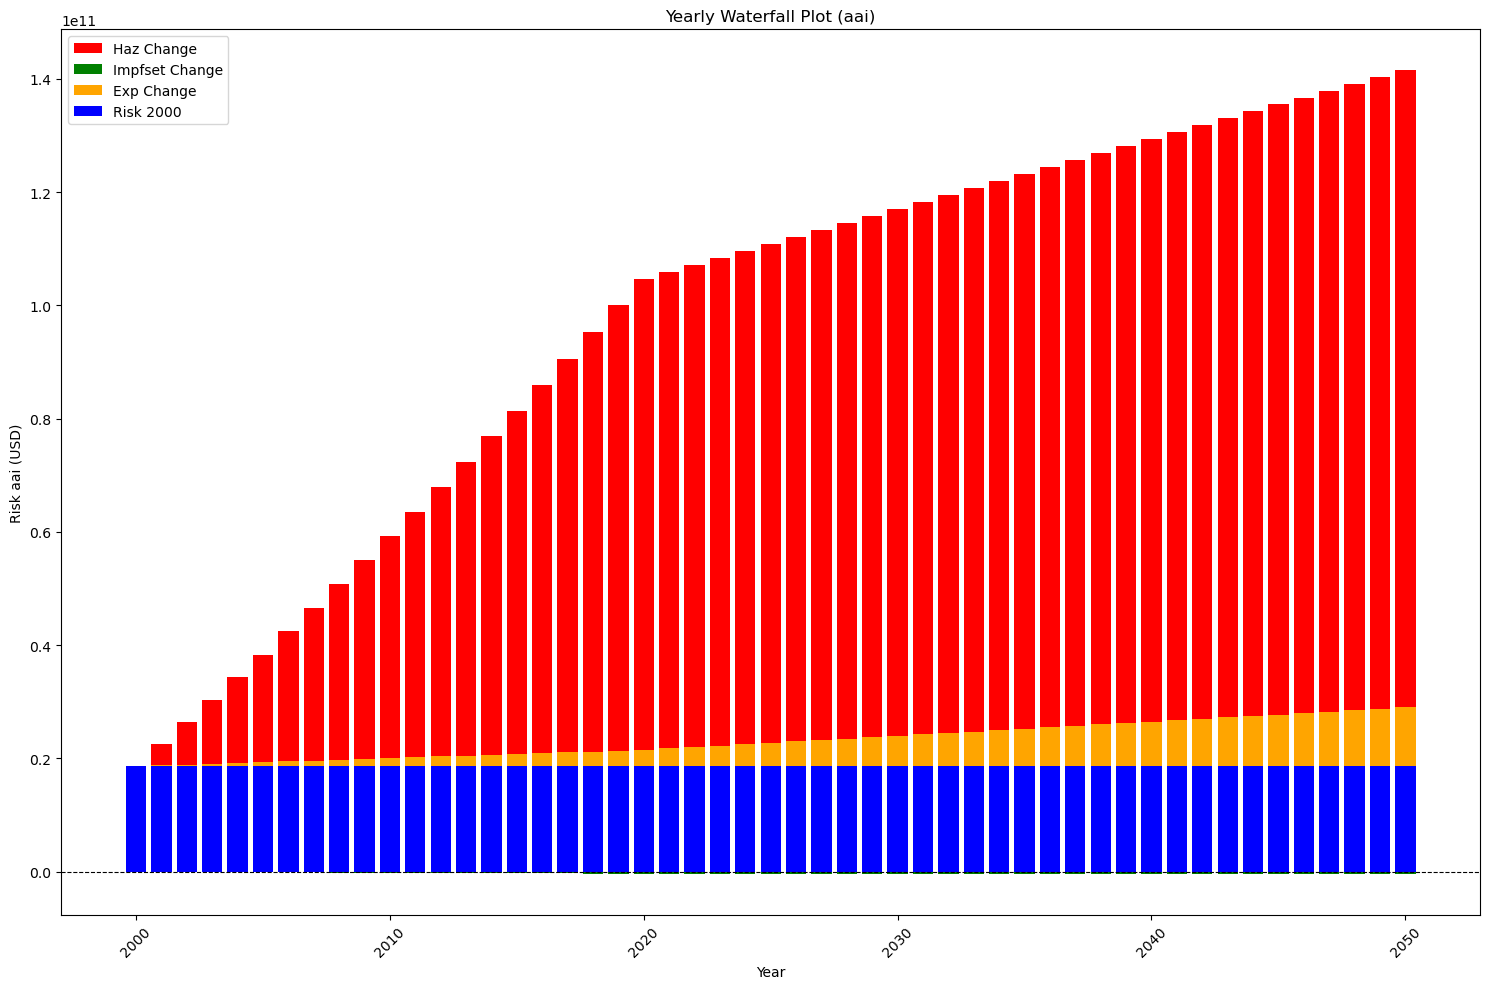

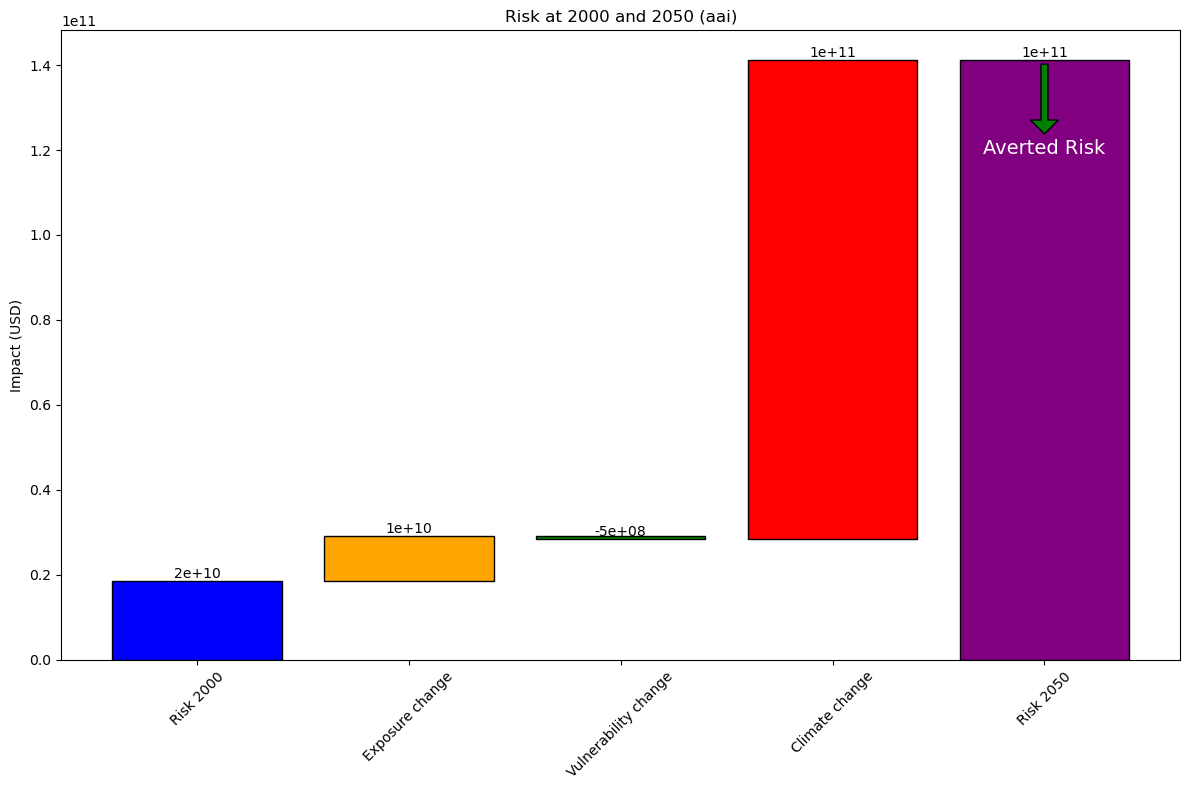

In [17]:
# Example usage:
# Calculate the yearly waterfall_df
waterfall_df = _calc_waterfall_plot_df(arm_df, all_arms_df, subtract=True)
# Plot the yearly waterfall
_plot_yearly_waterfall(waterfall_df)

# Example usage:
# Calculate the waterfall_df
waterfall_df = _calc_waterfall_plot_df(arm_df, all_arms_df, measure='Hazard_Int_Red_06')
# Plot the waterfall
_plot_correct_waterfall(waterfall_df)

## Step 3. Calculate the NPV risk metrics - Methods of the Risk Mterics Object

- Based on the following (stored in the risk_maetrics object)
    - arm_df
    - arm_static_dict
    - meusure_set
- Method
    - Generate a new RiskMetric object
        - Change new_meas_times_df ( retruns a new risk metrics object with a new measure set)
    - Plot
        - Waterfall plot(disc = None)
        - Risk per year plot(disc = yes)
        - Averted risk per year(disc = yes)
        - Cost per year(money_dis)
        - Cashflows_per_year(disc=True, risk=True, cost=true)
        - CB plots (NPV)
    - Print 
        - ann_CB_df, tot_CB_df
        - Results


## Utility functions

In [18]:
 # Copy the DataFrame to avoid modifying the original
averted_arm_df = pd.DataFrame(columns=arm_df.columns)

# Get the unique groups and metrics
groups = arm_df['group'].unique()
metrics = arm_df['metric'].unique()

# Iterate over each combination of group and metric
for group in groups:
    for metric in metrics:
        # Filter the DataFrame for the current group and metric
        if pd.isna(group):
            sub_df = arm_df[(arm_df['group'].isna()) & (arm_df['metric'] == metric)]
        else:
            sub_df = arm_df[(arm_df['group'] == group) & (arm_df['metric'] == metric)]

        # Get the risk metrics for the no measure
        no_meas_df = sub_df[sub_df['measure'] == 'no_measure'].sort_values('year')

        # Calculate the averted risk metrics for each measure
        for meas_name in sub_df['measure'].unique():
            if meas_name == 'no_measure':
                continue
            
            # Get the risk metrics for the measure
            meas_df = sub_df[sub_df['measure'] == meas_name].sort_values('year')

            # Align the DataFrames by year and calculate the averted risk
            sub_averted_risk_df =  meas_df.copy()
            sub_averted_risk_df['result'] = no_meas_df['result'].values - meas_df['result'].values

            # Concatenate the DataFrames
            if averted_arm_df.empty:
                averted_arm_df = sub_averted_risk_df
            else:
                averted_arm_df = pd.concat([averted_arm_df, sub_averted_risk_df], ignore_index=True)

# Reset the index
averted_arm_df.reset_index(drop=True, inplace=True)

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Get the active measures for a specific year
def get_active_measures_for_year(measure_set, year, incl_combo=False):
    
    # Get the DataFrame of the individul measure times
    meas_times_df = get_meas_times_df(measure_set, incl_combo)

    # Filter the DataFrame for the specified year
    active_measures = meas_times_df[(meas_times_df['start_year'] <= year) & (meas_times_df['end_year'] >= year)]['measure'].tolist()
    if not active_measures:
        active_measures = ['no_measure']
    return active_measures


# Get the name of the active combo measure
def get_name_of_active_combo(measure_set, active_measures):

    # Get the name of the active combo measure
    # Check if there is only one active measure then return its name
    if len(active_measures) == 1:
        return active_measures[0]

    # Get the DataFrame of the individul measure times
    for _,meas in measure_set.measures().items():
        if meas.combo and set(meas.combo) == set(active_measures):
                return meas.name

def calc_averted_risk_metrics(arm_df):
    # Copy the DataFrame to avoid modifying the original
    averted_arm_df = pd.DataFrame(columns=arm_df.columns)

    # Get the unique groups and metrics
    groups = arm_df['group'].unique()
    metrics = arm_df['metric'].unique()

    # Iterate over each combination of group and metric
    for group in groups:
        for metric in metrics:
            # Filter the DataFrame for the current group and metric
            if pd.isna(group):
                sub_df = arm_df[(arm_df['group'].isna()) & (arm_df['metric'] == metric)]
            else:
                sub_df = arm_df[(arm_df['group'] == group) & (arm_df['metric'] == metric)]

            # Get the risk metrics for the no measure
            no_meas_df = sub_df[sub_df['measure'] == 'no_measure'].sort_values('year')

            # Calculate the averted risk metrics for each measure
            for meas_name in sub_df['measure'].unique():
                #if meas_name == 'no_measure':
                #    continue
                
                # Get the risk metrics for the measure
                meas_df = sub_df[sub_df['measure'] == meas_name].sort_values('year')

                # Align the DataFrames by year and calculate the averted risk
                sub_averted_risk_df =  meas_df.copy()
                sub_averted_risk_df['result'] = no_meas_df['result'].values - meas_df['result'].values

                # Concatenate the DataFrames
                if averted_arm_df.empty:
                    averted_arm_df = sub_averted_risk_df
                else:
                    averted_arm_df = pd.concat([averted_arm_df, sub_averted_risk_df], ignore_index=True)

    # Reset the index
    averted_arm_df.reset_index(drop=True, inplace=True)

    return averted_arm_df

def plot_risk_metrics(arm_df, metric='aai', group=np.nan, averted=False, discounted=False, plot_type='line', measures=None, value_unit='USD'):
    # Filter the DataFrame
    if pd.isna(group):
        filt_arm_df = arm_df[(arm_df['group'].isna()) & (arm_df['metric'] == metric)]
    else:
        filt_arm_df = arm_df[(arm_df['group'] == group) & (arm_df['metric'] == metric)]

    # Filter the measures
    if measures:
        filt_arm_df = filt_arm_df[filt_arm_df['measure'].isin(measures)]

    # Ensure 'year' is treated as a categorical variable for bar plots
    filt_arm_df['year'] = filt_arm_df['year'].astype(str)

    # Create the plot
    plt.figure(figsize=(15, 8))
    
    if plot_type == 'bar':
        sns.barplot(data=filt_arm_df, x='year', y='result', hue='measure', errorbar=None, alpha=0.7)
    else:
        sns.lineplot(data=filt_arm_df, x='year', y='result', hue='measure')
    
    # Make y-axis from 0 to max aai with margin
    plt.ylim(0, filt_arm_df['result'].max() * 1.1)

    # Tilt the x-axis labels for better readability and display every nth year
    n = max(1, len(filt_arm_df['year'].unique()) // 20)  # Display every nth year, with a maximum of 20 labels
    plt.xticks(ticks=np.arange(0, len(filt_arm_df['year'].unique()), n), rotation=45)

    # Compressing the conditional logic for y-axis and title labels
    label_prefix = ('Discounted ' if discounted else '') + ('Averted ' if averted else '')
    value_label = f'{label_prefix}{metric} ({value_unit})'
    plt.ylabel(value_label)
    plt.title(f'{value_label} for each Measure over Years')

    # Move the legend to the right side, outside the plot
    plt.legend(title='Measure', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()

# Calculate the averted risk metrics
def calc_npv_cash_flows(cash_flows, start_year, end_year= None, disc=None):
    
    # Check if discount rates are provided
    if disc:
        if end_year is None:
            end_year = start_year + len(cash_flows) - 1
        # Get the discount rates 
        years = np.array(list(range(start_year, end_year + 1)))
        disc_years = np.intersect1d(years, disc.years)
        disc_rates = disc.rates[np.isin(disc.years, disc_years)]
        years = np.array([year for year in years if year in disc_years])
        # Calculate the discount factors
        discount_factors = []
        for idx, disc_rate in enumerate(disc_rates):
            discount_factors.append(1/(1 + disc_rate)**(years[idx] - start_year))
        discount_factors = np.array(discount_factors)
        # Return the discounted cash flows
        npv_cash_flows = cash_flows * discount_factors
    else:
        npv_cash_flows = cash_flows

    # Sum the discounted cash flows
    total_NPV = np.sum(npv_cash_flows)
    
    return npv_cash_flows, total_NPV


# Calculate the NPV for the arm_df
def calc_npv_arm_df(df, disc=None):
    # Copy the DataFrame
    disc_df = df.copy()
    npv_df = pd.DataFrame(columns=df.columns)
    
    for meas_name in disc_df['measure'].unique():
        for metric in disc_df['metric'].unique():
            for group_in in disc_df['group'].unique():
                
                # Handle NaN values in the 'group' column
                if pd.isna(group_in):
                    sub_df = disc_df[(disc_df['measure'] == meas_name) & 
                                     (disc_df['metric'] == metric) & 
                                     (disc_df['group'].isna())]
                else:
                    sub_df = disc_df[(disc_df['measure'] == meas_name) & 
                                     (disc_df['metric'] == metric) & 
                                     (disc_df['group'] == group_in)]
                
                cash_flows = sub_df['result'].values
                start_year = sub_df['year'].min()
                end_year = sub_df['year'].max()
                
                # Calculate the discounted cash flows and the total NPV
                npv_cash_flows, total_NPV = calc_npv_cash_flows(cash_flows, start_year, end_year, disc)
                
                # Update the 'result' column with the discounted cash flows
                disc_df.loc[sub_df.index, 'result'] = npv_cash_flows
                
                # Append the total NPV to the npv_df DataFrame
                npv_row = sub_df.iloc[0].copy()
                npv_row['result'] = total_NPV
                npv_df = pd.concat([npv_df, pd.DataFrame(npv_row).T])
                # Reset the index
                npv_df.reset_index(drop=True, inplace=True)
    
    # Drop the 'year' column from npv_df
    npv_df = npv_df.drop(columns=['year'])
    
    return disc_df, npv_df

def create_indv_meas_mod_arm_df(arm_df, measure_set, consider_measure_times=True):

    # Use start_year and end_year if they are provided and filter the arm_df
    start_year = arm_df['year'].min()
    end_year = arm_df['year'].max()

    # Filter the arm_df
    time_arm_df = arm_df.copy()

    # If the measure times should be considered
    if not consider_measure_times:
        return time_arm_df
    
    # Iterate over the measures in the measure set
    # Use start_year and end_year if they are provided and filter the arm_df
    time_arm_df = time_arm_df[time_arm_df['measure'] == 'no_measure'].copy()

    # Iterate over the measures in the measure set
    for _, meas in measure_set.measures().items():
        # Skip combo measures
        if meas.combo:
            continue

        measure_name = meas.name
        meas_start_year = meas.start_year
        meas_end_year = meas.end_year

        # Iterate over the years
        for year in range(start_year, end_year + 1):
            # If the measure is active this year, use its original results
            if meas_start_year <= year <= meas_end_year:
                mask = ((arm_df['measure'] == measure_name) & 
                        (arm_df['year'] == year))
                active_measure_df = arm_df.loc[mask]
                time_arm_df = pd.concat([time_arm_df, active_measure_df], ignore_index=True)
            else:
                # If the measure is not active this year, replace its values with the 'no_measure' values
                for metric in arm_df['metric'].unique():
                    for group_in in arm_df['group'].unique():
                        # Create a mask for the 'no_measure' rows for this year, metric, and group
                        mask = ((arm_df['measure'] == 'no_measure') & 
                                (arm_df['metric'] == metric) & 
                                (arm_df['year'] == year) & 
                                ((pd.isna(group_in) & arm_df['group'].isna()) | (arm_df['group'] == group_in)))

                        # Get the 'no_measure' result for this year, metric, and group
                        result = arm_df.loc[mask, 'result'].values

                        # Create a new DataFrame for this row
                        new_row = pd.DataFrame({'measure': [measure_name], 'group': [group_in], 'year': [year], 'metric': [metric], 'result': result})

                        # Concatenate the new row to the DataFrame
                        time_arm_df = pd.concat([time_arm_df, new_row], ignore_index=True)

    return time_arm_df

def create_meas_combo_time_mod_arm_df(arm_df, measure_set, consider_measure_times=True):

    # Calculate the risk for the combo measures
    # Use start_year and end_year if they are provided and filter the arm_df
    start_year = arm_df['year'].min()
    end_year = arm_df['year'].max()

    # Filter the arm_df
    time_arm_df = pd.DataFrame(columns=arm_df.columns)

    # # If the measure times should be considered
    if not consider_measure_times:
        return time_arm_df

    # Iterate over the measures in the measure set
    for _, meas in measure_set.measures().items():
        # Skip combo measures
        if not meas.combo:
            continue

        # Iterate over the years
        for year in range(start_year, end_year + 1):
            # Get the combos in the measure
            combo_measures = meas.combo
            measure_name = meas.name
            # Get the active measures for the year
            active_measures = get_active_measures_for_year(updated_measure_set, year)
            if len(active_measures) == 1:
                measure_to_use = active_measures[0]
            else:
                # Get the subset of active measures that are in the combo
                active_combo_measures = list(set(active_measures).intersection(combo_measures))
                # get the name of the active combo measure
                measure_to_use = get_name_of_active_combo(updated_measure_set, active_combo_measures)
            #print(f'For {measure_name} using {measure_to_use} for year {year}')

            # Filter the DataFrame for the current metric and measure to use
            sub_df = arm_df[(arm_df['measure'] == measure_to_use) & (arm_df['year'] == year)]

            # Update the measure name to the combo measure name
            sub_df['measure'] = measure_name

            # Append the values to the time_arm_df
            if time_arm_df.empty:
                time_arm_df = sub_df
            else:
                time_arm_df = pd.concat([time_arm_df, sub_df], ignore_index=True)


    return time_arm_df

def create_meas_mod_arm_df(arm_df, measure_set, consider_measure_times=True):

    # Calculate the risk for the individual measures
    mod_arm_indv_meas_df = create_indv_meas_mod_arm_df(arm_df, measure_set, consider_measure_times)

    # Calculate the risk for the combo measures
    mod_arm_combo_meas_df = create_meas_combo_time_mod_arm_df(arm_df, measure_set, consider_measure_times)

    # Concatenate the DataFrames
    mod_arm_df = pd.concat([mod_arm_indv_meas_df, mod_arm_combo_meas_df], ignore_index=True)

    # Reset the index
    mod_arm_df.reset_index(drop=True, inplace=True)

    return mod_arm_df

def calc_indv_measure_cash_flows_df(measure_set, start_year, end_year, consider_measure_times=True, disc=None):
    """
    This function calculates the cash flows for a set of measures over a specified time period.

    Parameters:
    measure_set: A set of measures for which to calculate cash flows.
    start_year: The first year of the time period.
    end_year: The last year of the time period.
    disc: The discount rate to apply to future cash flows.

    Returns:
    A DataFrame with the calculated cash flows for each measure.
    """

    # Initialize an empty DataFrame to store the cash flows
    costincome_df = pd.DataFrame(columns=['measure','year', 'cost', 'income', 'net'])

    # Loop over the measures in the set
    for _,meas in measure_set.measures().items():

        # If the measure is a combination of other measures, skip it
        if meas.combo:
            continue
        else:
            # If we should consider the start and end years of the measure, update the start and end years
            if consider_measure_times:
                meas_start_year = meas.start_year
                meas_end_year = meas.end_year
            else:
                meas_start_year = start_year
                meas_end_year = end_year

            # Calculate the cash flows for the measure
            temp_df = meas.cost_income.calc_cashflows_df(impl_year= meas_start_year, start_year=start_year, end_year=end_year, disc=disc)
            # Set all the cash flows to zero for years outside the measure period
            temp_df.loc[(temp_df['year'] < meas_start_year) | (temp_df['year'] > meas_end_year), ['cost', 'income', 'net']] = 0

            # Add the name of the measure to the DataFrame
            temp_df['measure'] = meas.name

            # If the cash flows DataFrame is empty, set it to the DataFrame for the current measure
            # Otherwise, concatenate the DataFrame for the current measure to the existing DataFrame
            if costincome_df.empty:
                costincome_df = temp_df
            else:
                costincome_df = pd.concat([costincome_df, temp_df])

        # Reset the index of the DataFrame
        costincome_df = costincome_df.reset_index(drop=True)

    # Return the DataFrame with the calculated cash flows
    return costincome_df

def calc_combo_measure_cash_flows_df(costincome_df, measure_set):

     # Calculate the cash flows for the combined measures dont reorder the columns
     costincome_combo_df = pd.DataFrame(columns=costincome_df.columns)

     # Loop over the measures in the set
     for _,meas in measure_set.measures().items():

          # If the measure is a combination of other measures, skip it
          if not meas.combo:
               continue
          else:
               #print(meas.name)
               # Get all the measures in the combo measure
               combo_measures = meas.combo
               # Get the sub df of the costincome_d
               sub_df = costincome_df[costincome_df['measure'].isin(combo_measures)]
               # For each year, sum the costs, incomes and net
               sub_df = sub_df.groupby('year').sum().reset_index()
               # Change the measure name to the combo measure name
               sub_df['measure'] = meas.name
               # Concatenate the sub_df to the costincome_combo_df
               if costincome_combo_df.empty:
                    costincome_combo_df = sub_df
               else:
                    costincome_combo_df = pd.concat([costincome_combo_df, sub_df])

     # Reset the index
     costincome_combo_df.reset_index(drop=True, inplace=True)

     # Concatenate the costincome_df and costincome_combo_df
     costincome_df = pd.concat([costincome_df, costincome_combo_df], ignore_index=True)

     return costincome_df

def calc_measure_cash_flows_df(measure_set, start_year, end_year, consider_measure_times=True, disc=None):

    # Calculate the individual measure cash flows
    costincome_df = calc_indv_measure_cash_flows_df(measure_set, start_year, end_year, consider_measure_times, disc)

    # Calculate the combo measure cash flows
    costincome_df = calc_combo_measure_cash_flows_df(costincome_df, measure_set)

    return costincome_df

## Calculate the ann_CB_df and tot_CB_df 


Create the CB data frame by merging the objects this can all be done using arm_df in the following steps
- ann_cb_df
    1. Modify Arm based on start and end year
    2. Get total risk column per year
    3. Get the averetd risk column
    4. Get the redisual risk column 
    5. Add the cost column 

- tot_cb_df
    - Comes as an output also 

##### Parameters

In [20]:
# Arguments for the CB analysis
from climada.entity import DiscRates

start_year = 2010 # Start year of the analysis (can also be none = the minimum year of arm_df)
end_year = 2025 # End year of the analysis (can also be none = the maximum year of arm_df)

# Determine if the measure times should be considered
consider_measure_times = True # Consider the measure times

# Discount rates (for the risk metrics and the costs) (can also be none = which is no discounting)
risk_disc = DiscRates(years=np.arange(1900, 2100), rates=np.ones(np.arange(1900, 2100).size) * 0.05) # Discount rates for the risk metrics
cost_disc = DiscRates(years=np.arange(1900, 2100), rates=np.ones(np.arange(1900, 2100).size) * 0.02) # Discount rates for the costs


In [21]:
# Calculate the cash flows for the measure set
costincome_df = calc_measure_cash_flows_df(updated_measure_set, start_year, end_year, consider_measure_times, cost_disc)

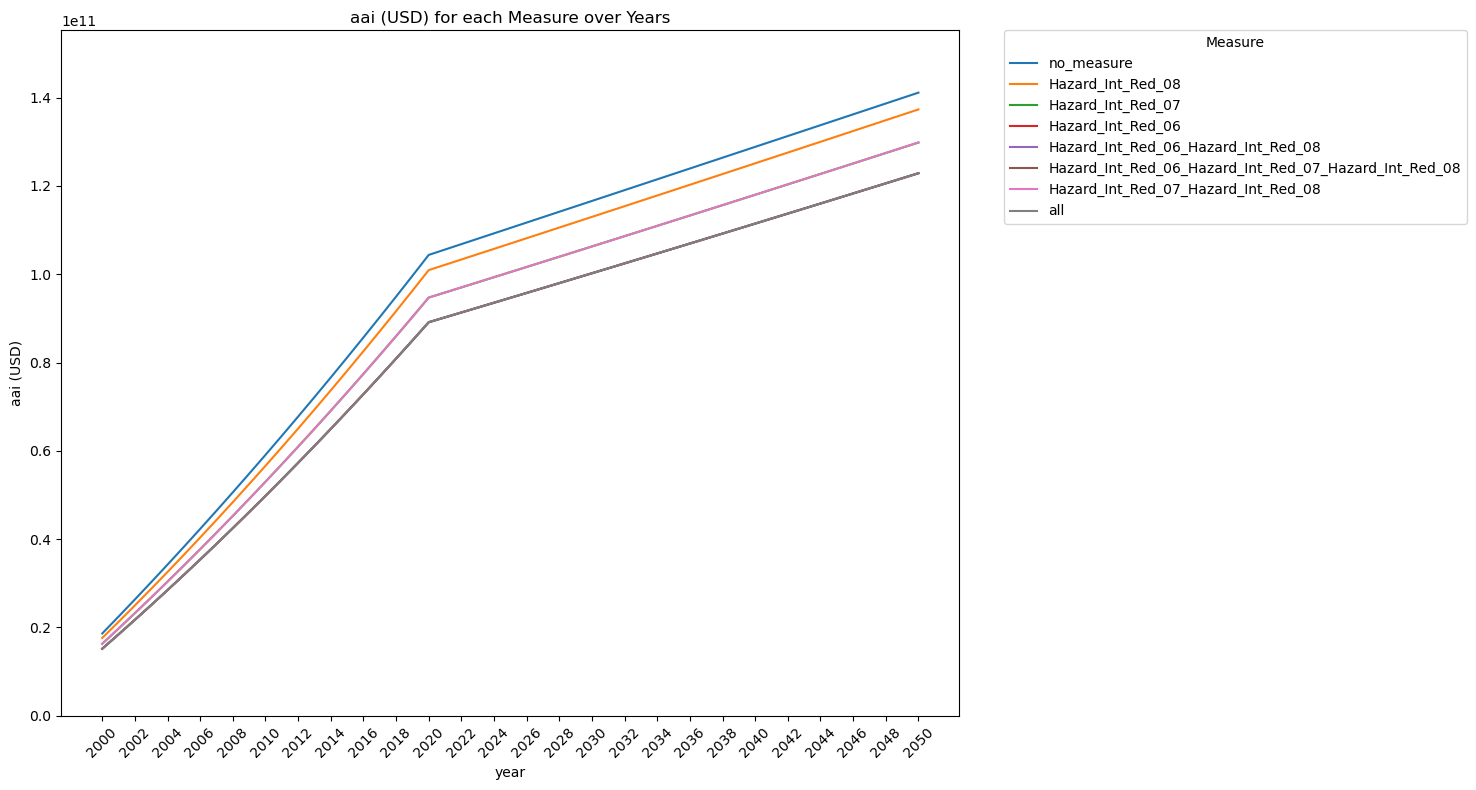

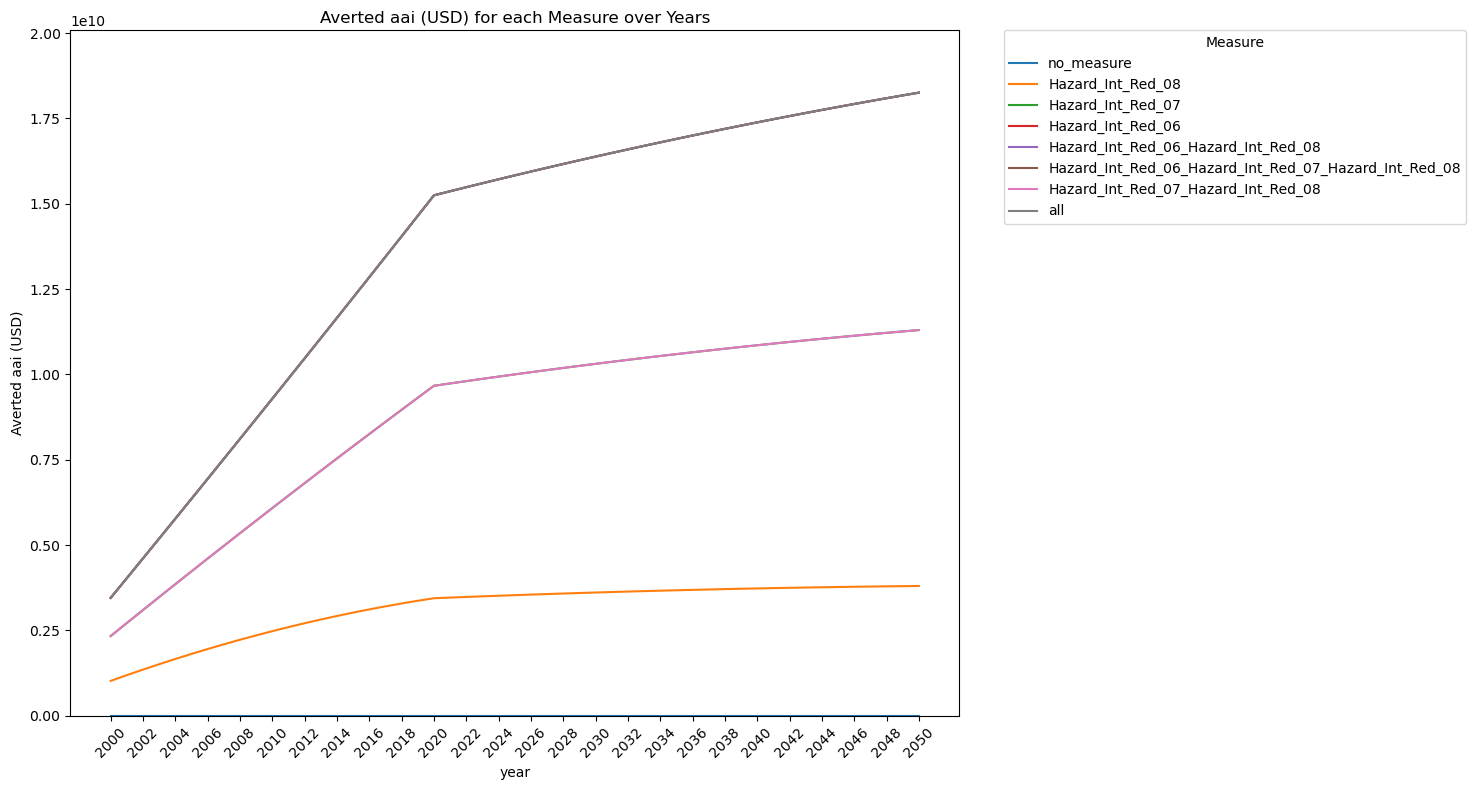

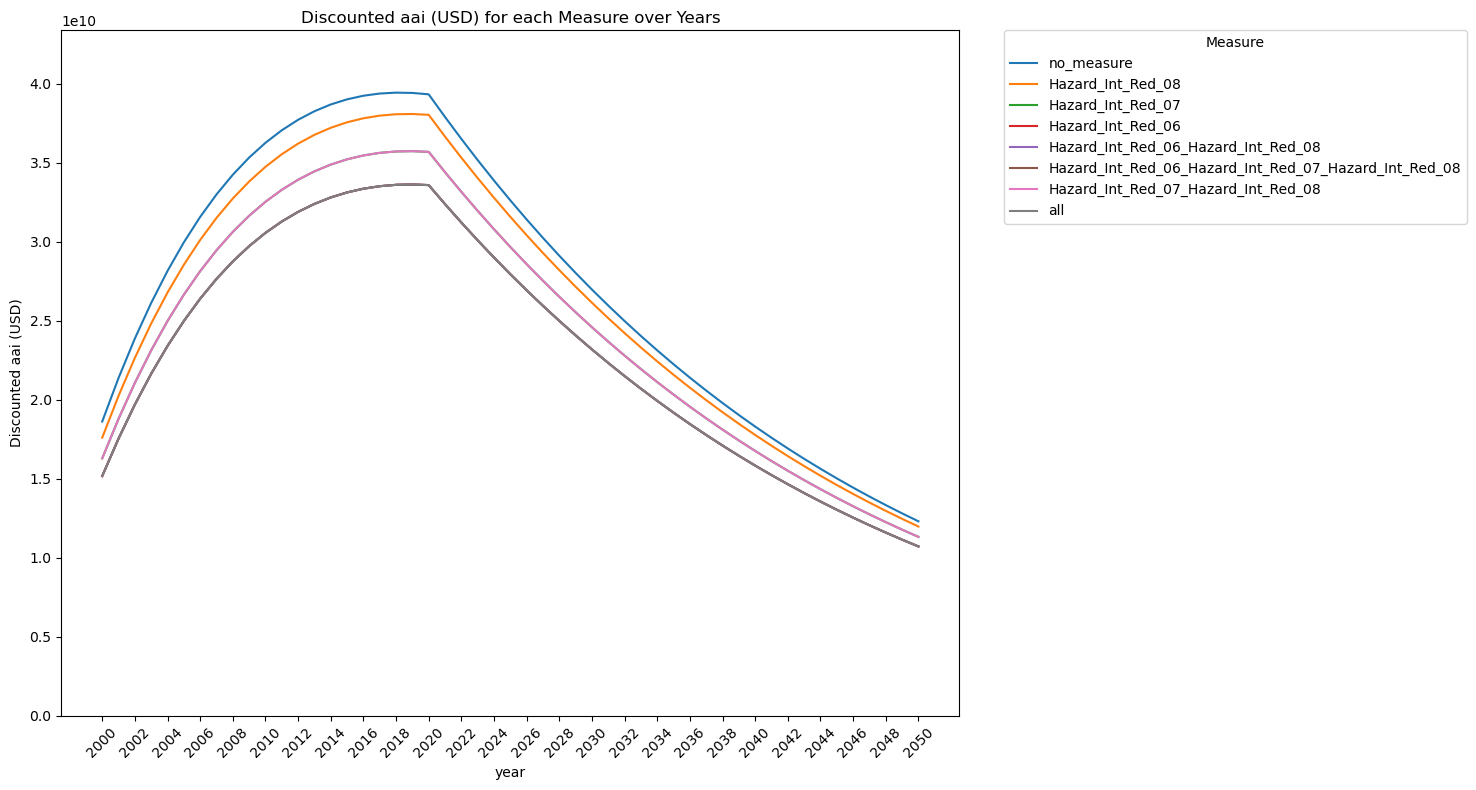

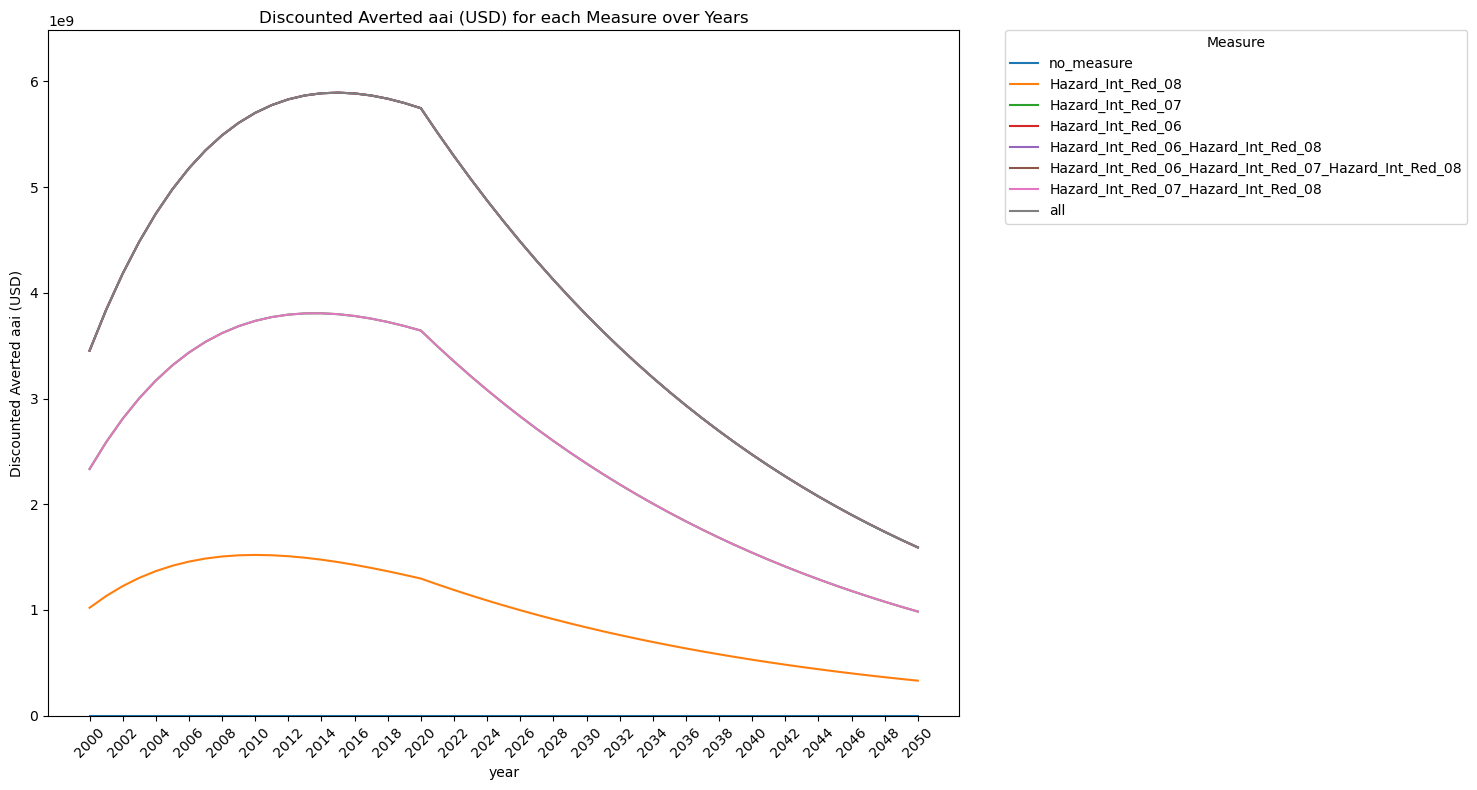

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot for each measure
plot_risk_metrics(arm_df)
# Plot the avereted risk metrics
averted_arm_df = calc_averted_risk_metrics(arm_df)
plot_risk_metrics(averted_arm_df, metric = 'aai', averted = True)
# Plot the discounted risk metrics
disc_arm_df, npv_arm_df = calc_npv_arm_df(arm_df, disc=risk_disc)
plot_risk_metrics(disc_arm_df, metric = 'aai', discounted = True)
# Plot the discounted averted risk metrics
disc_averted_arm_df, npv_averted_arm_df = calc_npv_arm_df(averted_arm_df, disc=risk_disc)
plot_risk_metrics(disc_averted_arm_df, metric = 'aai', discounted = True, averted = True)



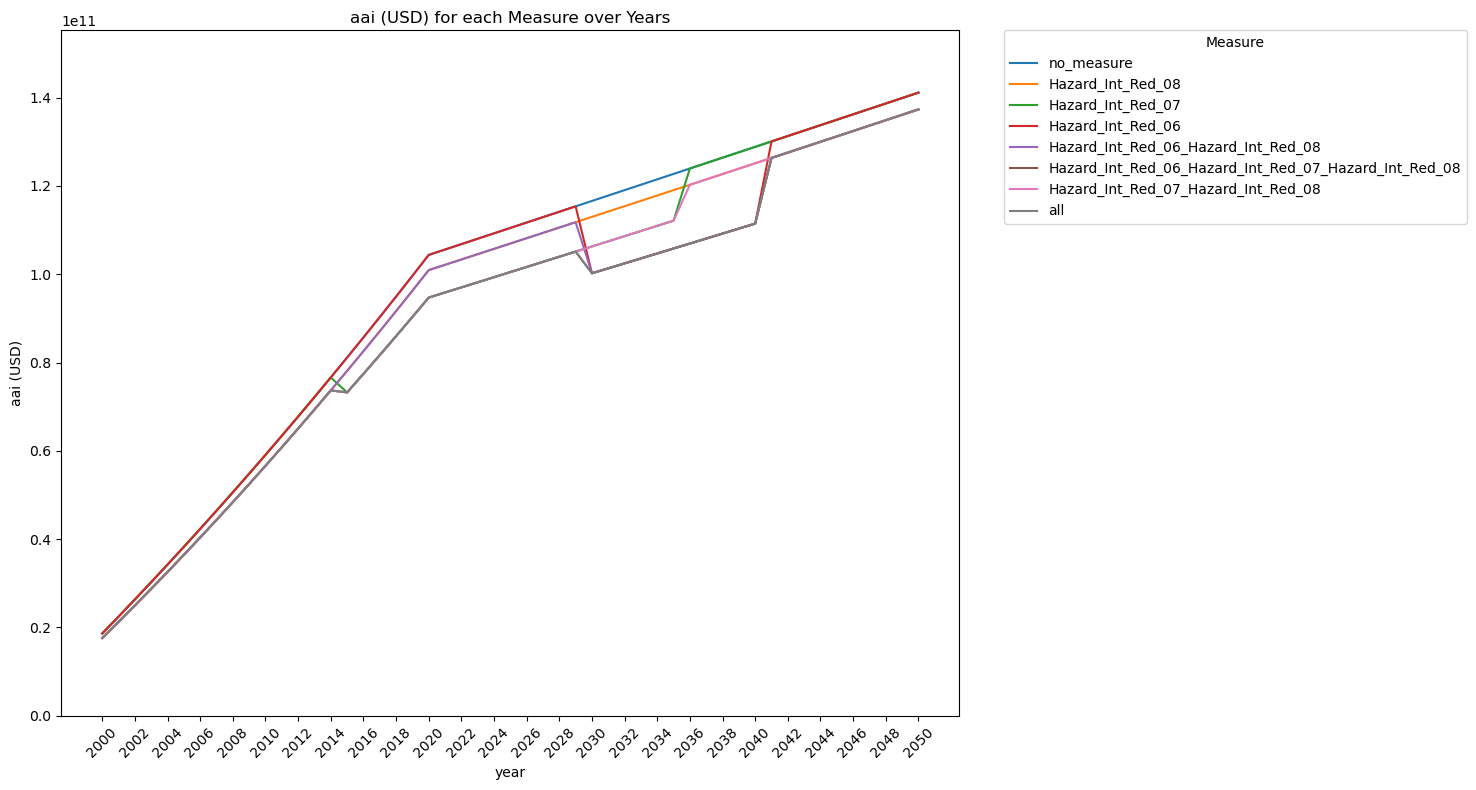

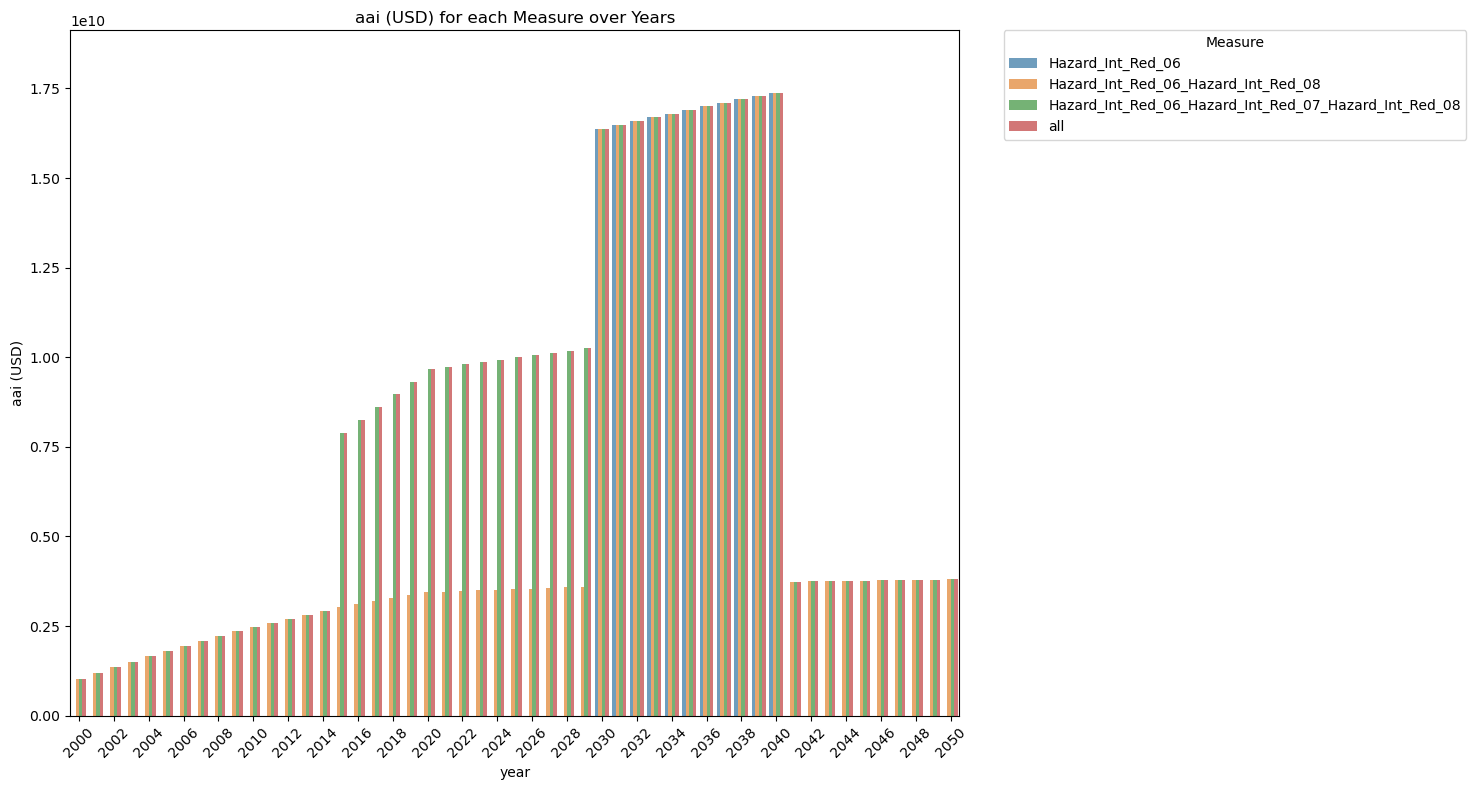

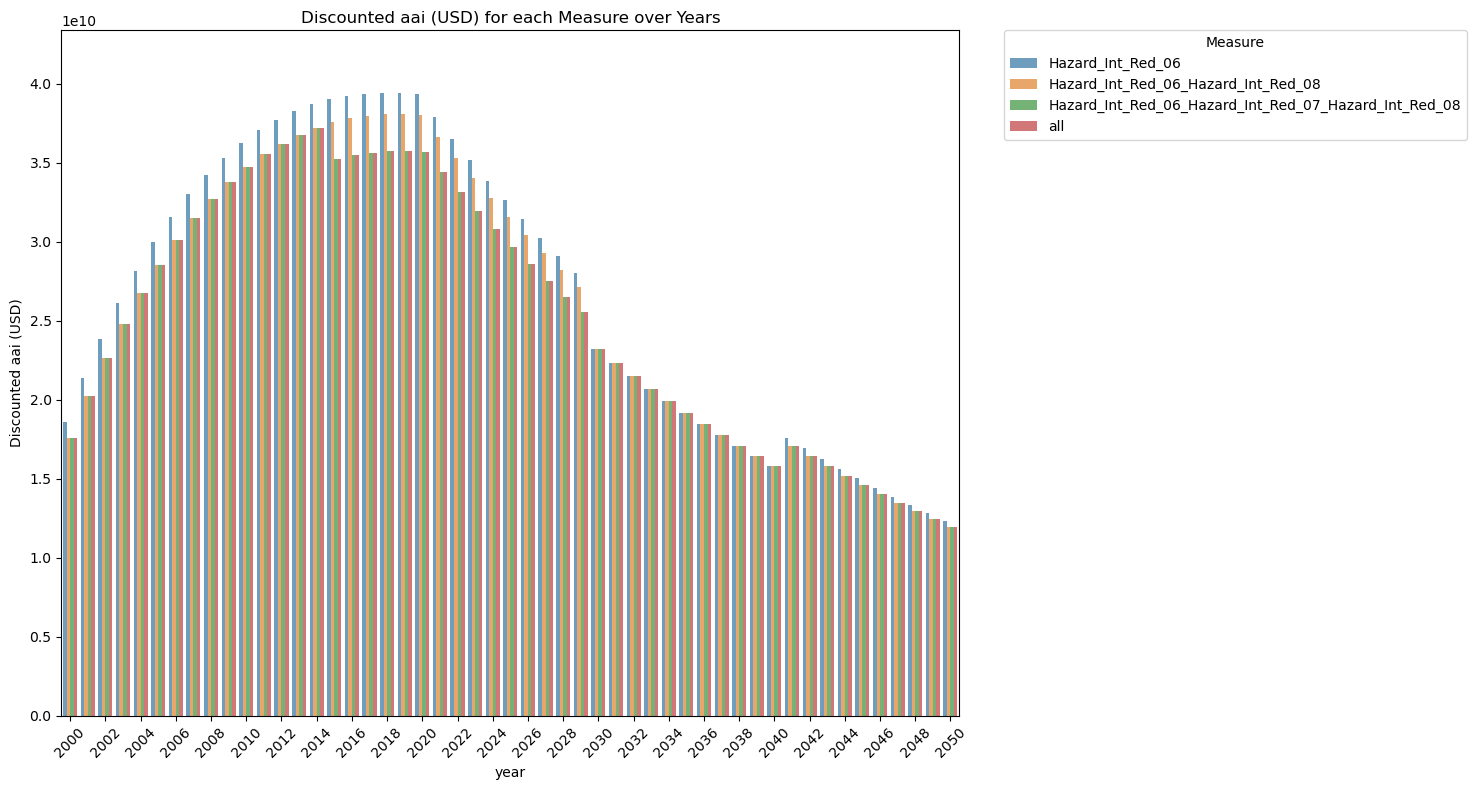

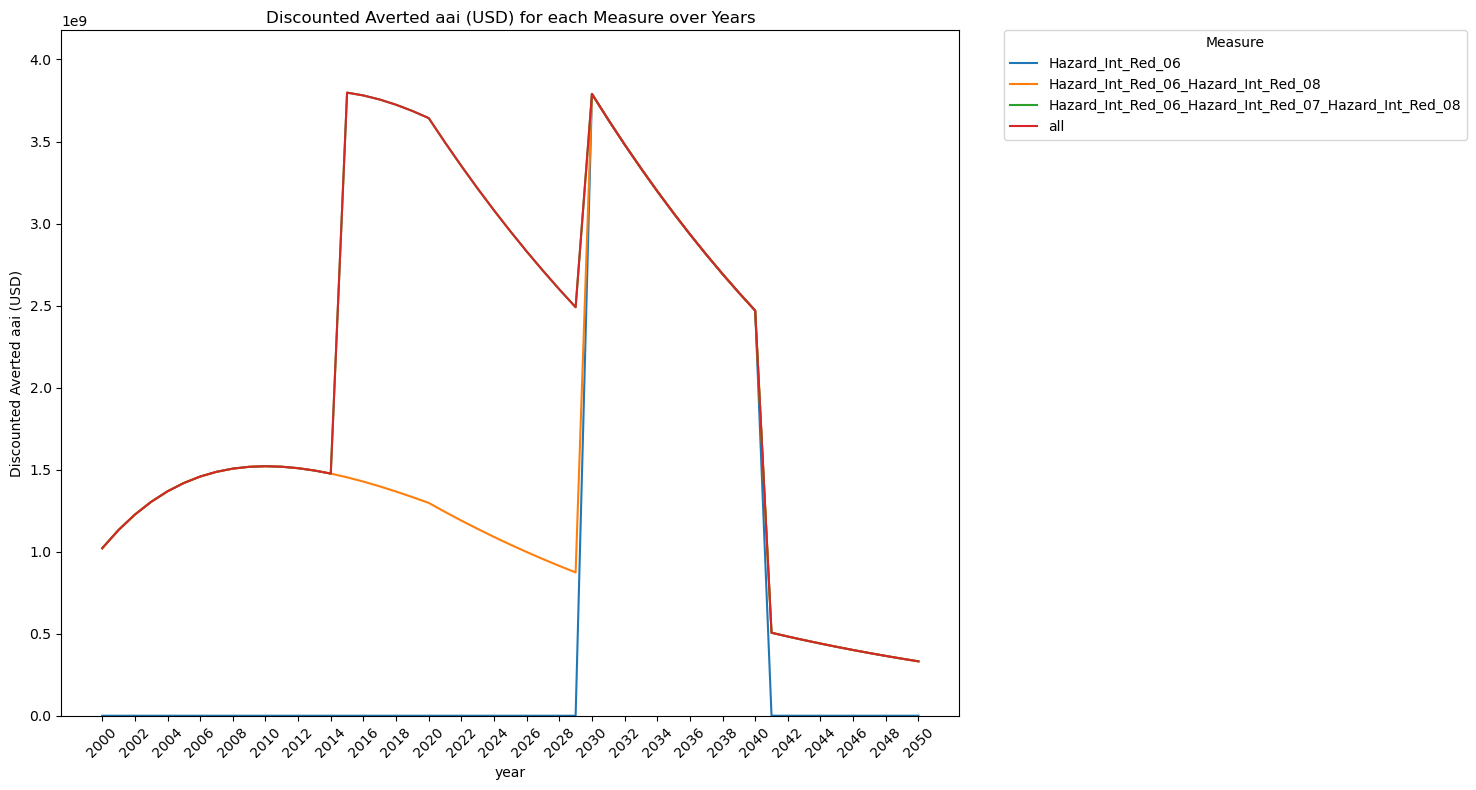

In [23]:
# Calculate the arm_d considering the time periods of the measures
#time_arm_df = create_meas_mod_arm_df(arm_df, measure_set, consider_measure_times=True)
time_arm_df = create_meas_mod_arm_df(arm_df, updated_measure_set, consider_measure_times=True)
measures = ['Hazard_Int_Red_06',  'Hazard_Int_Red_06_Hazard_Int_Red_08', 'Hazard_Int_Red_06_Hazard_Int_Red_07_Hazard_Int_Red_08', 'all']

# Plot the risk metrics for each measure
plot_risk_metrics(time_arm_df)

# Plot the averted risk metrics for each measure
averted_time_arm_df = calc_averted_risk_metrics(time_arm_df)
plot_risk_metrics(averted_time_arm_df, metric='aai', plot_type='bar', measures=measures)

# Calculate the discounted cash flows for the measures calc_npv_arm_df(averted_time_arm_df, disc=risk_disc)
disc_time_arm_df, npv_time_arm_df = calc_npv_arm_df(time_arm_df, disc=risk_disc)
plot_risk_metrics(disc_time_arm_df, metric='aai', discounted=True, measures=measures, plot_type='bar')

# Calculate the discounted averted cash flows for the measures
disc_averted_time_arm_df, npv_averted_time_arm_df = calc_npv_arm_df(averted_time_arm_df, disc=risk_disc)
plot_risk_metrics(disc_averted_time_arm_df, metric='aai', discounted=True, averted=True, measures=measures)


#### Step 1. Get the arm_df for each measures time considered
- consider_measure_times
- exp_disc_rates

In [24]:
# # Calculate the averted risk when considering the measure times without discounting
# if start_year is None:
#     start_year = arm_df['year'].min()
# if end_year is None:
#     end_year = arm_df['year'].max()

# # Step 1 - Filter the arm_df based on the start_year and end_year
# filt_arm_df = arm_df[(arm_df['year'] >= start_year) & (arm_df['year'] <= end_year)]

# # Step 2 - Create the modified arm_df based on the measure times
# filt_arm_df = create_meas_mod_arm_df(filt_arm_df, measure_set, consider_measure_times)

# # Step 3 - Calculate the NPV of the arm_df to get total risk
# disc_filt_arm_df, _ = calc_npv_arm_df(filt_arm_df, disc=risk_disc)

# # Get the base CB dataframe
# ann_CB_df = filt_arm_df[['measure', 'year', 'group', 'metric', 'result']].copy()
# ann_CB_df.columns = ['measure', 'year', 'group', 'metric', 'total risk']

# # Step 4 - Calculate the averted risk metrics
# averted_arm_df = calc_averted_risk_metrics(disc_filt_arm_df)

# plot_risk_metrics(averted_arm_df, metric='aai', averted=True)

# # Rename the column 'result' to 'averted risk'
# averted_arm_df = averted_arm_df.rename(columns={'result': 'averted risk'})



# # Merge the averted risk metrics to the CB dataframe
# ann_CB_df = ann_CB_df.merge(averted_arm_df, on=['measure', 'year', 'group', 'metric'], how='left')

# # Calculate the residual risk
# ann_CB_df['residual risk'] = ann_CB_df['total risk'] - ann_CB_df['averted risk']

#  # Calculate the measure cash flows
# costincome_df = calc_measure_cash_flows_df(measure_set, start_year, end_year, consider_measure_times, disc=cost_disc)

# # Merge the costincome_df with the ann_CB_df but only keep the 'net' column and rename it to 'cost (net)'
# ann_CB_df = ann_CB_df.merge(costincome_df[['measure', 'year', 'net']], on=['measure', 'year'], how='left')
# ann_CB_df = ann_CB_df.rename(columns={'net': 'cost (net)'})

# # For group that is not nan, fill the 'cost (net)' column with nan
# ann_CB_df.loc[~ann_CB_df['group'].isna(), 'cost (net)'] = np.nan

# # Step 6 - Aggregate the results
# # Cast the 'group' column to string type and fill NaN values with a placeholder
# ann_CB_df['group'] = ann_CB_df['group'].astype(str).fillna('No Group')

# # Aggregate the results

# # Cast the 'group' column to string type and fill NaN values with a placeholder
# ann_CB_df['group'] = ann_CB_df['group'].astype(str).fillna('No Group')
# # Aggregate the results
# tot_CB_df = ann_CB_df.groupby(['measure', 'group', 'metric']).sum().reset_index()
# # Drop the 'year' column
# tot_CB_df = tot_CB_df.drop(columns=['year'])

# # Step 7 - Calculate the CB ratio
# # Calculate the CB ratio
# tot_CB_df['B/C ratio'] = tot_CB_df['averted risk'] / -tot_CB_df['cost (net)']


In [27]:
import pandas as pd
import numpy as np
from tabulate import tabulate

def calc_CB_df(arm_df, measure_set, start_year=None, end_year=None, consider_measure_times=True, risk_disc=None, cost_disc=None):
    """
    This function calculates the cost-benefit analysis (CB) for a set of measures.

    Parameters:
    arm_df: A DataFrame with the risk metrics for each measure.
    measure_set: A set of measures for which to calculate the CB.
    start_year: The first year of the analysis (can also be none = the minimum year of arm_df).
    end_year: The last year of the analysis (can also be none = the maximum year of arm_df).
    consider_measure_times: A boolean indicating if the measure times should be considered.
    risk_disc: The discount rate to apply to future risk metrics.
    cost_disc: The discount rate to apply to future costs.

    Returns:
    A DataFrame with the calculated cost-benefit analysis.
    """

    # Calculate the averted risk when considering the measure times without discounting
    if start_year is None:
        start_year = arm_df['year'].min()
    if end_year is None:
        end_year = arm_df['year'].max()

    # Step 1 - Filter the arm_df based on the start_year and end_year
    filt_arm_df = arm_df[(arm_df['year'] >= start_year) & (arm_df['year'] <= end_year)]

    # Step 2 - Create the modified arm_df based on the measure times
    filt_arm_df = create_meas_mod_arm_df(filt_arm_df, measure_set, consider_measure_times)

    # Step 3 - Calculate the NPV of the arm_df to get total risk
    disc_filt_arm_df, _ = calc_npv_arm_df(filt_arm_df, disc=risk_disc)

    # Get the base CB dataframe
    ann_CB_df = filt_arm_df[['measure', 'year', 'group', 'metric', 'result']].copy()
    ann_CB_df.columns = ['measure', 'year', 'group', 'metric', 'total risk']

    # Step 4 - Calculate the averted risk metrics
    averted_arm_df = calc_averted_risk_metrics(disc_filt_arm_df)
    # Rename the column 'result' to 'averted risk'
    averted_arm_df = averted_arm_df.rename(columns={'result': 'averted risk'})

    # Merge the averted risk metrics to the CB dataframe
    ann_CB_df = ann_CB_df.merge(averted_arm_df, on=['measure', 'year', 'group', 'metric'], how='left')

    # Calculate the residual risk
    ann_CB_df['residual risk'] = ann_CB_df['total risk'] - ann_CB_df['averted risk']

    # Calculate the measure cash flows
    costincome_df = calc_measure_cash_flows_df(measure_set, start_year, end_year, consider_measure_times, disc=cost_disc)

    # Merge the costincome_df with the ann_CB_df but only keep the 'net' column and rename it to 'cost (net)'
    ann_CB_df = ann_CB_df.merge(costincome_df[['measure', 'year', 'net']], on=['measure', 'year'], how='left')
    ann_CB_df = ann_CB_df.rename(columns={'net': 'cost (net)'})
    # For group that is not nan, fill the 'cost (net)' column with nan
    ann_CB_df.loc[~ann_CB_df['group'].isna(), 'cost (net)'] = np.nan

    # Step 6 - Aggregate the results
    # Cast the 'group' column to string type and fill NaN values with a placeholder
    ann_CB_df['group'] = ann_CB_df['group'].astype(str).fillna('No Group')

    # Aggregate the results

    # Cast the 'group' column to string type and fill NaN values with a placeholder
    ann_CB_df['group'] = ann_CB_df['group'].astype(str).fillna('No Group')
    # Aggregate the results
    tot_CB_df = ann_CB_df.groupby(['measure', 'group', 'metric']).sum().reset_index()
    # Drop the 'year' column
    tot_CB_df = tot_CB_df.drop(columns=['year'])

    # Step 7 - Calculate the CB ratio
    # Calculate the CB ratio
    tot_CB_df['B/C ratio'] = tot_CB_df['averted risk'] / -tot_CB_df['cost (net)']

    return ann_CB_df, tot_CB_df

def print_CB_summary_table(tot_CB_df, metric='aai', value_unit='USD', group= np.nan):

    df_filtered = tot_CB_df[tot_CB_df['metric'] == metric]

    # Filter the DataFrame based on the group
    # cast the 'group' to string type
    group = str(group)
    df_filtered = df_filtered[df_filtered['group'] == group]

    # Total Climate risk is the 'no_measure' risk for the given metric
    total_climate_risk = df_filtered[df_filtered['measure'] == 'no_measure']['total risk'].sum()

    # Annual risk is the Total risk divided by the number of years (assuming 30 years for this example)
    annual_risk = df_filtered['total risk'].sum() / 30

    # Smallest possible residual risk across the measures
    residual_risk = df_filtered[df_filtered['measure'] != 'no_measure']['residual risk'].min()

    # Determine the appropriate unit based on the magnitude
    if total_climate_risk >= 1e12:
        unit = 'Bn'
        divisor = 1e9
    elif total_climate_risk >= 1e9:
        unit = 'Mn'
        divisor = 1e6
    else:
        unit = ''
        divisor = 1

    # Prepare data for the measures table
    measure_data = df_filtered[df_filtered['measure'] != 'no_measure']
    measure_summary = []
    for measure in measure_data['measure'].unique():
        measure_df = measure_data[measure_data['measure'] == measure]
        total_cost = measure_df['cost (net)'].sum()
        total_benefit = measure_df['averted risk'].sum()
        bc_ratio = total_benefit / total_cost if total_cost != 0 else np.nan
        measure_summary.append([measure, total_cost / divisor, total_benefit / divisor, bc_ratio])

    measure_summary_df = pd.DataFrame(measure_summary, columns=['Measure', f'Cost ({value_unit} {unit})', f'Benefit ({value_unit} {unit})', 'Benefit/Cost'])

    # Print the measure summary table
    print(tabulate(measure_summary_df, headers='keys', tablefmt='pretty'))

    # Print the total summary
    total_summary = [
        ['Total climate risk:', total_climate_risk / divisor],
        ['Average annual risk:', annual_risk / divisor],
        ['Residual risk:', residual_risk / divisor]
    ]

    print("\n--------------------  ---------")
    for item in total_summary:
        print(f"{item[0]:<22} {item[1]:>11.3f}  ({value_unit} {unit})")
    print("--------------------  ---------")



def plot_yearly_averted_cost(ann_CB_df, measure, metric='aai', group=None, averted=False, discounted=False, value_unit='USD'):
    # Filter the dataframe
    df_filtered = ann_CB_df[(ann_CB_df['measure'] == measure) & (ann_CB_df['metric'] == metric)]
    
    if group is not None:
        df_filtered = df_filtered[df_filtered['group'] == group]
    
    # Replace None with 0 in 'cost (net)' for plotting
    df_filtered['cost (net)'] = df_filtered['cost (net)'].fillna(0)
    
    # Separate positive and negative values for stacking correctly
    positive_averted_risks = df_filtered['averted risk'].clip(lower=0)
    negative_averted_risks = df_filtered['averted risk'].clip(upper=0)
    positive_net_costs = df_filtered['cost (net)'].clip(lower=0)
    negative_net_costs = df_filtered['cost (net)'].clip(upper=0)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(15, 8))
    
    years = df_filtered['year'].unique()
    
    # Plot positive values
    ax.bar(years, positive_averted_risks, color='green', label='Averted Risk')
    ax.bar(years, positive_net_costs, bottom=positive_averted_risks, color='red', label='Net Cost')
    
    # Plot negative values
    ax.bar(years, negative_averted_risks, color='green')
    ax.bar(years, negative_net_costs, bottom=negative_averted_risks, color='red')
    
    # Construct y-axis label and title based on parameters
    label_prefix = ('Discounted ' if discounted else '') + ('Averted ' if averted else '')
    value_label = f'{label_prefix}Amount ({value_unit})'
    title_label = f'Yearly {label_prefix}Risk vs Net Cost for {measure} ({metric})'
    
    ax.set_ylabel(value_label)
    ax.set_title(title_label)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)  # Move legend to top
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=45, ha='right')  # Improve x-axis readability

    # Add grid line at y=0
    ax.axhline(0, color='black', linewidth=0.5)

    # set the y-axis limit to the maximum value and minimum value multiplied by 1.1
    ax.set_ylim(df_filtered[['averted risk', 'cost (net)']].values.min() * 1.5, df_filtered[['averted risk', 'cost (net)']].values.max() * 1.1)

    plt.tight_layout()
    plt.show()



### Plot and print the resulst

#### Classic print

+---+-------------------------------------------------------+-----------------------+--------------------+---------------------+
|   |                        Measure                        |     Cost (USD Bn)     |  Benefit (USD Bn)  |    Benefit/Cost     |
+---+-------------------------------------------------------+-----------------------+--------------------+---------------------+
| 0 |                   Hazard_Int_Red_06                   | -0.016526922330367344 | 33.98831363034058  | -2056.5422255230696 |
| 1 | Hazard_Int_Red_06_Hazard_Int_Red_07_Hazard_Int_Red_08 | -0.07157944189949979  | 108.18716058869542 | -1511.4278306415722 |
| 2 |          Hazard_Int_Red_06_Hazard_Int_Red_08          | -0.04511280619141246  | 76.79367992005878  | -1702.2589903679498 |
| 3 |                   Hazard_Int_Red_07                   | -0.026466635708087327 | 61.98986403712257  | -2342.1890383363125 |
| 4 |          Hazard_Int_Red_07_Hazard_Int_Red_08          | -0.05505251956913245  | 89.98845218

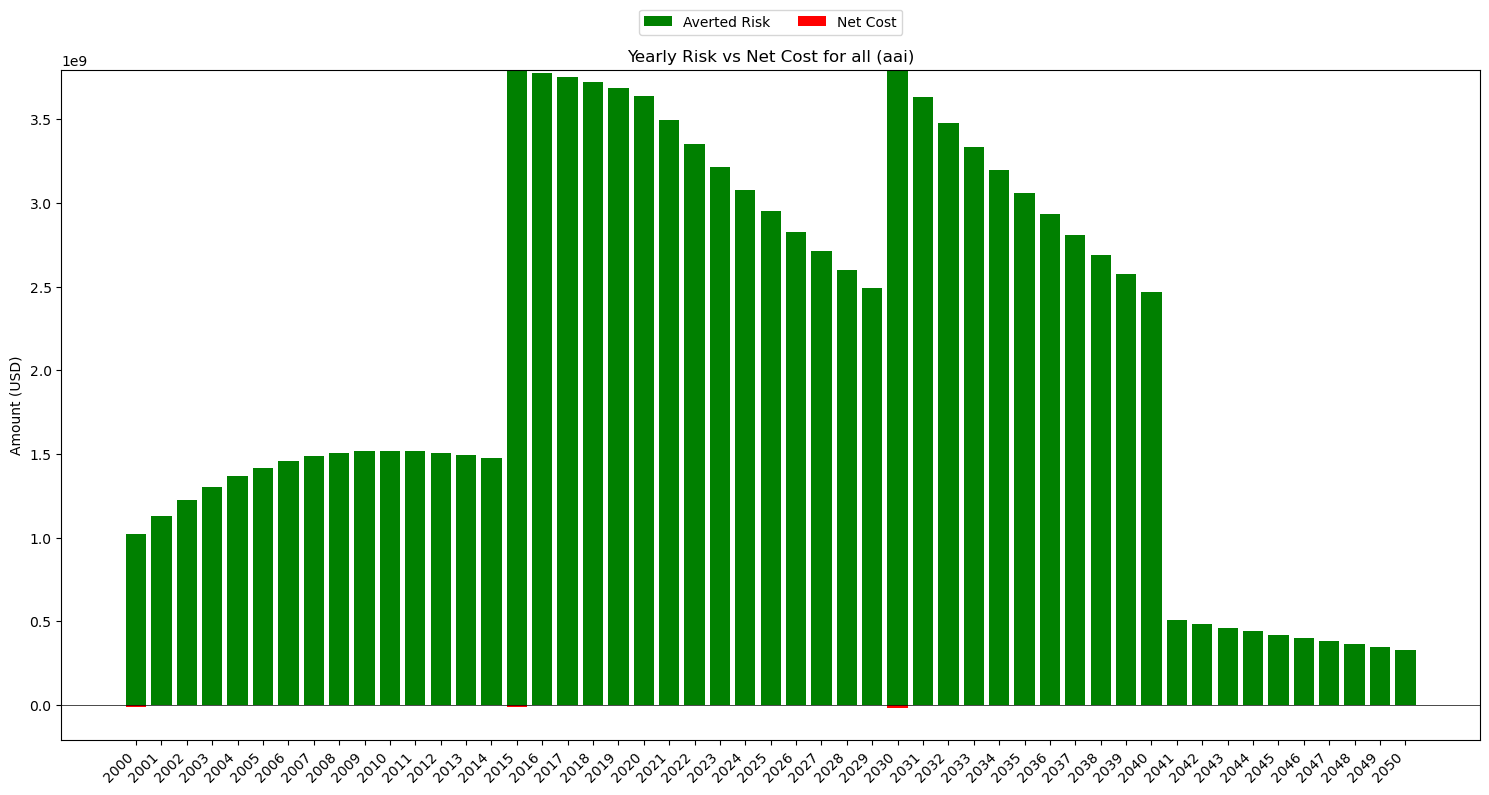

In [42]:
# Calculate the cost-benefit analysis
ann_CB_df, tot_CB_df = calc_CB_df(arm_df, updated_measure_set, start_year=None, end_year=None, consider_measure_times=True, risk_disc=risk_disc, cost_disc=cost_disc)

# Print the total cost-benefit analysis summary table
print_CB_summary_table(tot_CB_df)

# Plot the yearly averted cost for a specific measure
plot_yearly_averted_cost(ann_CB_df, measure='all')




In [ ]:
import pandas as pd
from typing import Optional

class ImpactMetrics:

    def __init__(self, 
                 arm_df: pd.DataFrame,
                 all_arms_df: pd.DataFrame,
                 measure_set: Optional[MeasureSet] = None,
                 value_unit: str = 'USD'
                 ):
        self.arm_df = arm_df.copy()
        self.all_arms_df = all_arms_df.copy()
        self.measure_set = copy.deepcopy(measure_set)
        self.value_unit = value_unit


    ## Waterfall plot functions
    # Plot the waterfall plot
    def waterfall_plot(self, yearly=False, measure=None, metric='aai', ref_year=None, fut_year=None, group=np.nan):

        # Check if yearly or classic waterfall plot
        if yearly:
            waterfall_df = _calc_waterfall_plot_df(self.arm_df, self.all_arms_df, measure=measure, metric=metric, ref_year=ref_year, fut_year=fut_year, group=group)
            _plot_yearly_waterfall(waterfall_df, self.value_unit)
        else:
            waterfall_df = _calc_waterfall_plot_df(self.arm_df, self.all_arms_df, measure=measure, metric=metric, ref_year=ref_year, fut_year=fut_year, group=group)
            _plot_correct_waterfall(waterfall_df, self.value_unit)

        return
    
    ## CB analysis
    # Calculate the cost-benefit analysis
    def calc_CB(self, start_year=None, end_year=None, consider_measure_times=True, risk_disc=None, cost_disc=None):
        return calc_CB_df(self.arm_df, self.measure_set, start_year, end_year, consider_measure_times, risk_disc, cost_disc)
    
    # Print the CB summary table
    def print_CB_summary_table(self, start_year=None, end_year=None, consider_measure_times=True, risk_disc=None, cost_disc=None):
        # Get the CB analysis
        ann_CB_df, tot_CB_df = self.calc_CB(start_year, end_year, consider_measure_times, risk_disc, cost_disc)
        print_CB_summary_table(ann_CB_df)

        return
    
    # Plot the yearly averted cost for a specific measure
    def plot_yearly_cost_vs_benefit(self, measure, metric='aai', start_year=None, end_year=None, consider_measure_times=True, risk_disc=None, cost_disc=None):
        ann_CB_df, tot_CB_df = self.calc_CB(start_year, end_year, consider_measure_times, risk_disc, cost_disc)
        plot_yearly_averted_cost(ann_CB_df, measure, metric, group=None)
        return
    
    ## Risk analysis
    # Plot the risk metrics for each measure
    def plot_yearly_risk_metrics(self, metric='aai', averted= True, risk_disc=None, plot_type='bar', measures=None):

        # Check if the risk metrics should be avereted
        if averted:
            # Get the avereted risk metrics
            plot_df = calc_averted_risk_metrics(self.arm_df)
        
        # check if the risk metrics should be discounted
        if risk_disc is not None:
            # Calculate the discounted cash flows
            plot_df, _ = calc_npv_arm_df(plot_df, disc=risk_disc)
            discounted = True

        # Plot the risk metrics
        plot_risk_metrics(plot_df, metric=metric, group=np.nan, averted=averted, discounted=discounted, plot_type=plot_type, measures=measures, value_unit=self.value_unit)
       
        return


    
# Cretae the impact metrics object
impact_metrics_test = ImpactMetrics(arm_df, all_arms_df, measure_set)

## Waterfall analysis
# Plot the waterfall
impact_metrics_test.waterfall_plot(yearly=False)
# Plot the yearly waterfall
impact_metrics_test.waterfall_plot(yearly=True)

## Cost-benefit analysis
# Print the cost-benefit summary table
impact_metrics_test.print_CB_summary_table(consider_measure_times=True, risk_disc=risk_disc, cost_disc=cost_disc)
# Plot the yearly averted cost for a specific measure
impact_metrics_test.plot_yearly_cost_vs_benefit(measure='all', metric='aai', risk_disc=risk_disc, cost_disc=cost_disc)

## Risk analysis
# Plot the risk metrics for each measure
impact_metrics_test.plot_yearly_risk_metrics(metric='aai', averted= True, risk_disc=risk_disc, plot_type='bar', measures=None)